# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [5]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [6]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [7]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [8]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [9]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [10]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [11]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [12]:
def make_model(): 
    model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [13]:
original_X = X
original_Y = y 

In [14]:
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)

2021-10-30 00:04:35.496890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 00:04:35.839000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
3/3 [==============================] - 2s 424ms/step - loss: 0.6975 - accuracy: 0.4625 - precision_1: 0.4783 - recall_1: 0.5366 - val_loss: 0.6322 - val_accuracy: 0.5500 - val_precision_1: 0.5000 - val_recall_1: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 389ms/step - loss: 0.7452 - accuracy: 0.5125 - precision_1: 0.5128 - recall_1: 0.9756 - val_loss: 0.6150 - val_accuracy: 0.5000 - val_precision_1: 0.4737 - val_recall_1: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 376ms/step - loss: 0.6478 - accuracy: 0.6000 - precision_1: 0.5634 - recall_1: 0.9756 - val_loss: 0.6180 - val_accuracy: 0.5500 - val_precision_1: 0.5000 - val_recall_1: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6500 - accuracy: 0.6125 - precision_1: 0.5862 - recall_1: 0.8293 - val_loss: 0.5919 - val_accuracy: 0.9000 - val_precision_1: 0.8182 - val_recall_1: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6261 -

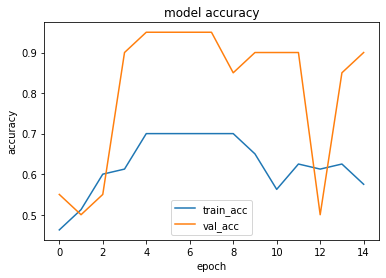

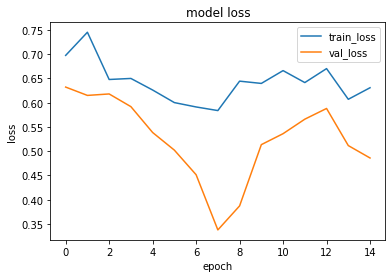

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 3206.65it/s]


prediction for video armflapping_1.mov is [[0.5237686]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.5028606]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.5637326]]


1it [00:00, 13934.56it/s]


prediction for video control_1.mov is [[0.48816553]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.46578062]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.46560237]]
Epoch 1/75
3/3 [==============================] - 1s 326ms/step - loss: 0.6640 - accuracy: 0.6250 - precision_2: 0.6552 - recall_2: 0.4872 - val_loss: 0.7163 - val_accuracy: 0.6000 - val_precision_2: 0.6154 - val_recall_2: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 386ms/step - loss: 0.6009 - accuracy: 0.6875 - precision_2: 0.6591 - recall_2: 0.7436 - val_loss: 0.7104 - val_accuracy: 0.6000 - val_precision_2: 0.6364 - val_recall_2: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 379ms/step - loss: 0.5161 - accuracy: 0.8000 - precision_2: 0.8108 - recall_2: 0.7692 - val_loss: 0.8726 - val_accuracy: 0.6000 - val_precision_2: 0.6364 - val_recall_2: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 399ms/step - loss: 0.6210 - accuracy: 0.7000 - precision_2: 0.6744 - recall_2: 0.7436 - val_loss: 0.9067 - val_accuracy: 0.6000 - val_precision_2: 0.6154 - val_recall_2: 0.7273
Epoch 5/75
3/3 [===========

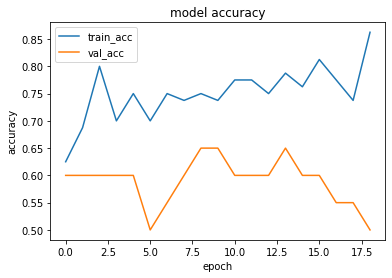

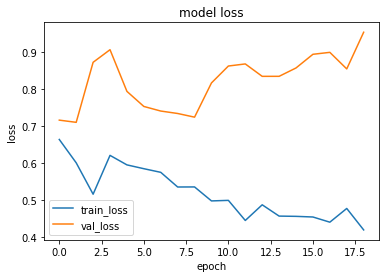

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.8133785]]


1it [00:00, 7244.05it/s]


prediction for video armflapping_3.mov is [[0.41420025]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_2.mov is [[0.69123924]]


1it [00:00, 12483.05it/s]


prediction for video control_1.mov is [[0.15273812]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.2516093]]


1it [00:00, 19152.07it/s]


prediction for video control_3.mov is [[0.12125623]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6833 - accuracy: 0.5000 - precision_3: 0.5088 - recall_3: 0.7073 - val_loss: 0.7126 - val_accuracy: 0.5500 - val_precision_3: 0.5000 - val_recall_3: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6155 - accuracy: 0.6750 - precision_3: 0.6531 - recall_3: 0.7805 - val_loss: 0.7347 - val_accuracy: 0.6000 - val_precision_3: 0.5455 - val_recall_3: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.5480 - accuracy: 0.7875 - precision_3: 0.7609 - recall_3: 0.8537 - val_loss: 0.6970 - val_accuracy: 0.5500 - val_precision_3: 0.5000 - val_recall_3: 0.4444
Epoch 4/75
3/3 [==============================] - 1s 358ms/step - loss: 0.5736 - accuracy: 0.7500 - precision_3: 0.8000 - recall_3: 0.6829 - val_loss: 0.6730 - val_accuracy: 0.5000 - val_precision_3: 0.4286 - val_recall_3: 0.3333
Epoch 5/75
3/3 [===========

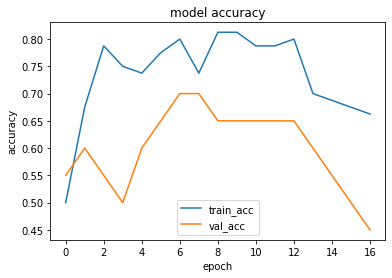

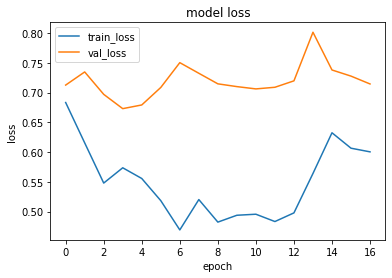

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.3404289]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.48923564]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.44740337]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.23825958]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.21014655]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.20935509]]
Epoch 1/75
3/3 [==============================] - 1s 317ms/step - loss: 0.7503 - accuracy: 0.5250 - precision_4: 0.5263 - recall_4: 0.7317 - val_loss: 0.7398 - val_accuracy: 0.5500 - val_precision_4: 0.5000 - val_recall_4: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6429 - accuracy: 0.7500 - precision_4: 0.7333 - recall_4: 0.8049 - val_loss: 0.6283 - val_accuracy: 0.8000 - val_precision_4: 0.7778 - val_recall_4: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6666 - accuracy: 0.6000 - precision_4: 0.6957 - recall_4: 0.3902 - val_loss: 0.5733 - val_accuracy: 0.8000 - val_precision_4: 0.8571 - val_recall_4: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6352 - accuracy: 0.6625 - precision_4: 0.7188 - recall_4: 0.5610 - val_loss: 0.5554 - val_accuracy: 0.6500 - val_precision_4: 0.5833 - val_recall_4: 0.7778
Epoch 5/75
3/3 [===========

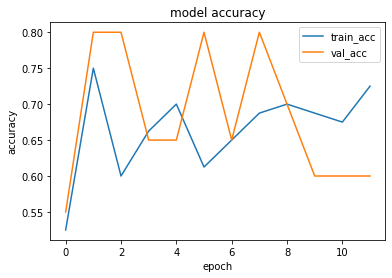

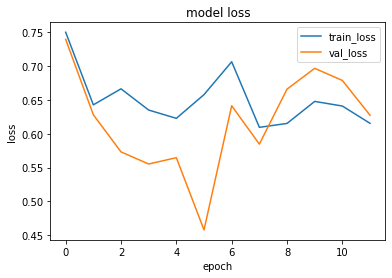

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5397143]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.5865067]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.6424327]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.45895436]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.42143288]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.4016989]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7068 - accuracy: 0.5625 - precision_5: 0.5366 - recall_5: 0.5789 - val_loss: 0.6940 - val_accuracy: 0.5500 - val_precision_5: 1.0000 - val_recall_5: 0.2500
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6482 - accuracy: 0.6250 - precision_5: 0.6538 - recall_5: 0.4474 - val_loss: 0.5799 - val_accuracy: 0.7000 - val_precision_5: 0.7143 - val_recall_5: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6502 - accuracy: 0.6625 - precision_5: 0.6341 - recall_5: 0.6842 - val_loss: 0.6248 - val_accuracy: 0.7000 - val_precision_5: 1.0000 - val_recall_5: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.5715 - accuracy: 0.6875 - precision_5: 0.6970 - recall_5: 0.6053 - val_loss: 0.5665 - val_accuracy: 0.7000 - val_precision_5: 0.7143 - val_recall_5: 0.8333
Epoch 5/75
3/3 [============

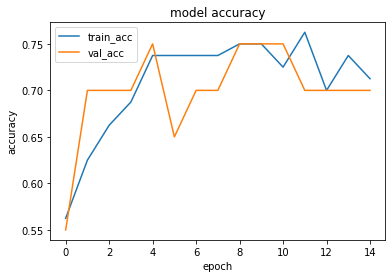

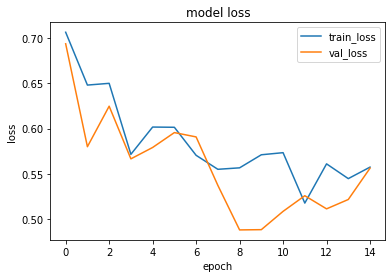

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.36933187]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.3817416]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.54145634]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.2840743]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.2313304]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.2462742]]


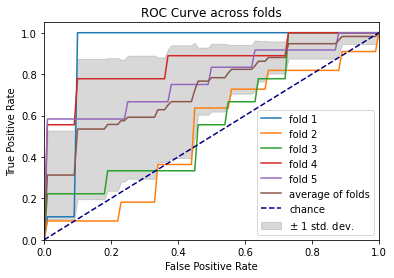

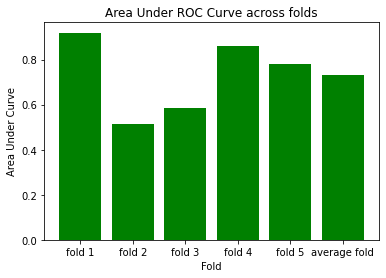

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.7252 - accuracy: 0.4875 - precision_7: 0.5000 - recall_7: 0.6341 - val_loss: 0.8265 - val_accuracy: 0.5500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 350ms/step - loss: 0.7228 - accuracy: 0.5250 - precision_7: 1.0000 - recall_7: 0.0732 - val_loss: 0.7294 - val_accuracy: 0.5500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6552 - accuracy: 0.6000 - precision_7: 0.6216 - recall_7: 0.5610 - val_loss: 0.6268 - val_accuracy: 0.5000 - val_precision_7: 0.4737 - val_recall_7: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6438 - accuracy: 0.6250 - precision_7: 0.5821 - recall_7: 0.9512 - val_loss: 0.5728 - val_accuracy: 0.6000 - val_precision_7: 0.5294 - val_recall_7: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 296ms/step 

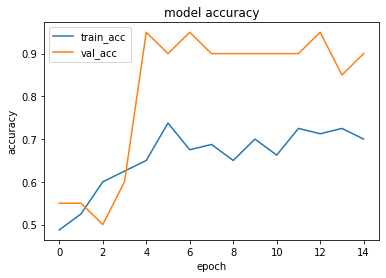

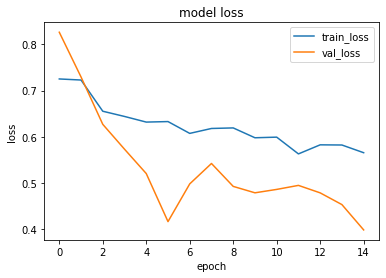

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5105791]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.50920194]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.59960705]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.4503744]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.4190718]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.40428767]]
Epoch 1/75
3/3 [==============================] - 1s 335ms/step - loss: 0.6778 - accuracy: 0.5375 - precision_8: 0.5250 - recall_8: 0.5385 - val_loss: 0.7130 - val_accuracy: 0.5500 - val_precision_8: 0.5500 - val_recall_8: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6796 - accuracy: 0.6250 - precision_8: 0.5692 - recall_8: 0.9487 - val_loss: 0.8321 - val_accuracy: 0.4000 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6440 - accuracy: 0.6250 - precision_8: 0.8000 - recall_8: 0.3077 - val_loss: 0.7246 - val_accuracy: 0.4500 - val_precision_8: 0.5000 - val_recall_8: 0.2727
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.5723 - accuracy: 0.7375 - precision_8: 0.8000 - recall_8: 0.6154 - val_loss: 0.7271 - val_accuracy: 0.6000 - val_precision_8: 0.6667 - val_recall_8: 0.5455
Epoch 5/75
3/3 [===

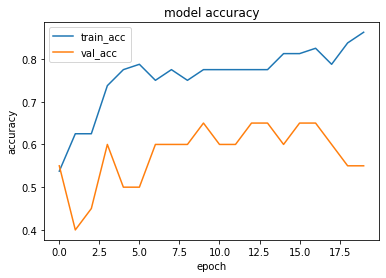

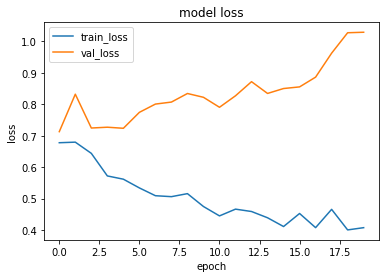

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.6226699]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.62914217]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.7943314]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.18843931]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.17532894]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.17315438]]
Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.7387 - accuracy: 0.3875 - precision_9: 0.4286 - recall_9: 0.5854 - val_loss: 0.6720 - val_accuracy: 0.6000 - val_precision_9: 0.5556 - val_recall_9: 0.5556
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6811 - accuracy: 0.6500 - precision_9: 0.7097 - recall_9: 0.5366 - val_loss: 0.6472 - val_accuracy: 0.6000 - val_precision_9: 0.6667 - val_recall_9: 0.2222
Epoch 3/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6502 - accuracy: 0.6875 - precision_9: 0.8077 - recall_9: 0.5122 - val_loss: 0.6562 - val_accuracy: 0.5500 - val_precision_9: 0.5000 - val_recall_9: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6318 - accuracy: 0.6375 - precision_9: 0.6000 - recall_9: 0.8780 - val_loss: 0.6613 - val_accuracy: 0.6500 - val_precision_9: 0.5833 - val_recall_9: 0.7778
Epoch 5/75
3/3 [===========

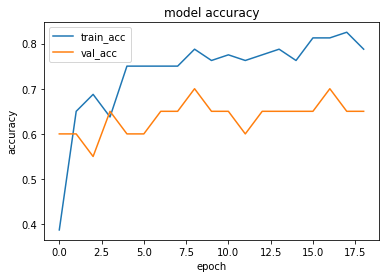

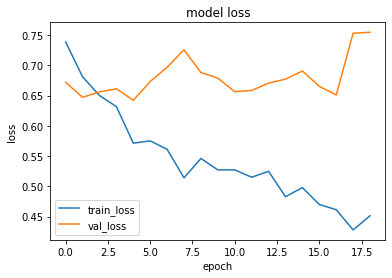

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.59213907]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.47956857]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.7465081]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.41125947]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.2716655]]


1it [00:00, 20360.70it/s]


prediction for video control_3.mov is [[0.27750635]]
Epoch 1/75
3/3 [==============================] - 1s 327ms/step - loss: 0.7082 - accuracy: 0.3750 - precision_10: 0.4151 - recall_10: 0.5366 - val_loss: 0.6143 - val_accuracy: 0.8000 - val_precision_10: 0.6923 - val_recall_10: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6687 - accuracy: 0.5750 - precision_10: 0.6207 - recall_10: 0.4390 - val_loss: 0.5933 - val_accuracy: 0.7500 - val_precision_10: 0.6667 - val_recall_10: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6480 - accuracy: 0.7125 - precision_10: 0.6957 - recall_10: 0.7805 - val_loss: 0.5917 - val_accuracy: 0.6500 - val_precision_10: 0.5714 - val_recall_10: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 374ms/step - loss: 0.6558 - accuracy: 0.6875 - precision_10: 0.7105 - recall_10: 0.6585 - val_loss: 0.5586 - val_accuracy: 0.7500 - val_precision_10: 0.7500 - val_recall_10: 0.6667
Epoch 5/75


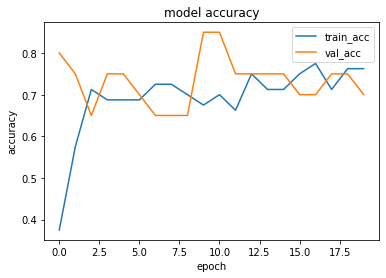

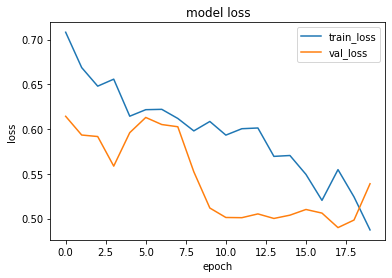

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.73746145]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.8479693]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.82711995]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.20943928]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.19123363]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.19013804]]
Epoch 1/75
3/3 [==============================] - 1s 313ms/step - loss: 0.7119 - accuracy: 0.5125 - precision_11: 0.4898 - recall_11: 0.6316 - val_loss: 0.7134 - val_accuracy: 0.5000 - val_precision_11: 1.0000 - val_recall_11: 0.1667
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6691 - accuracy: 0.6625 - precision_11: 0.7619 - recall_11: 0.4211 - val_loss: 0.6498 - val_accuracy: 0.7000 - val_precision_11: 1.0000 - val_recall_11: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6509 - accuracy: 0.7000 - precision_11: 0.7333 - recall_11: 0.5789 - val_loss: 0.5964 - val_accuracy: 0.7500 - val_precision_11: 0.8182 - val_recall_11: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 307ms/step - loss: 0.5970 - accuracy: 0.7375 - precision_11: 0.6977 - recall_11: 0.7895 - val_loss: 0.5326 - val_accuracy: 0.7000 - val_precision_11: 0.7143 - val_recall_11: 0.8333
Epoch 5/75


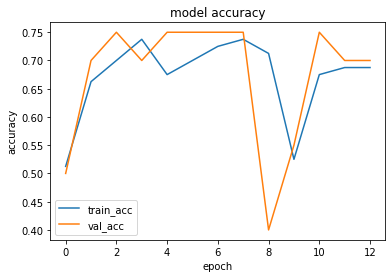

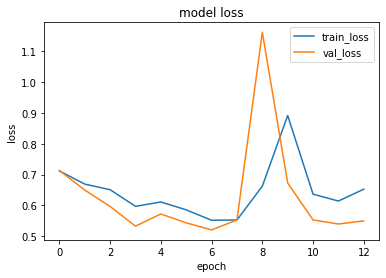

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.31300375]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.47998738]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.57135594]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.36930197]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.28271624]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.32167917]]


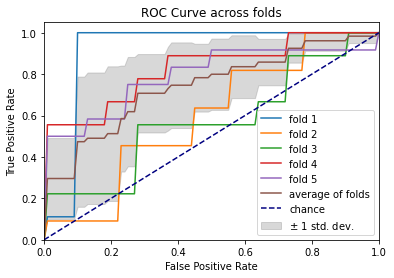

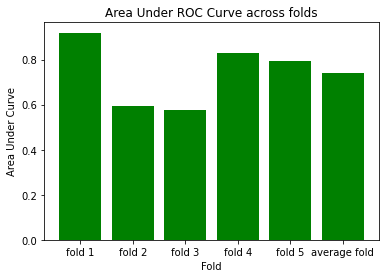

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7017 - accuracy: 0.5375 - precision_13: 0.5312 - recall_13: 0.8293 - val_loss: 0.7401 - val_accuracy: 0.4500 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.7040 - accuracy: 0.3875 - precision_13: 0.3182 - recall_13: 0.1707 - val_loss: 0.6766 - val_accuracy: 0.3500 - val_precision_13: 0.3750 - val_recall_13: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6743 - accuracy: 0.5500 - precision_13: 0.5352 - recall_13: 0.9268 - val_loss: 0.6178 - val_accuracy: 0.5000 - val_precision_13: 0.4737 - val_recall_13: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6486 - accuracy: 0.5875 - precision_13: 0.5606 - recall_13: 0.9024 - val_loss: 0.5955 - val_accuracy: 0.9500 - val_precision_13: 0.9000 - val_recall_13: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 294

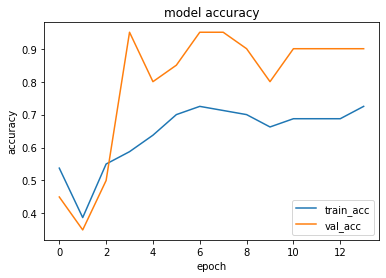

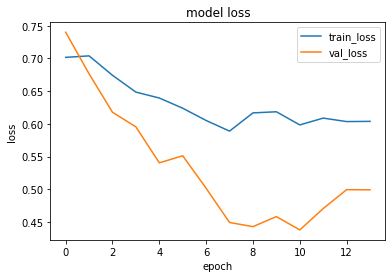

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.50467384]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.4674893]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.51786226]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.48205665]]


1it [00:00, 15420.24it/s]


prediction for video control_2.mov is [[0.4716049]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.4681692]]
Epoch 1/75
3/3 [==============================] - 1s 342ms/step - loss: 0.6696 - accuracy: 0.5750 - precision_14: 0.5410 - recall_14: 0.8462 - val_loss: 0.7353 - val_accuracy: 0.5500 - val_precision_14: 0.6000 - val_recall_14: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6241 - accuracy: 0.7125 - precision_14: 0.6739 - recall_14: 0.7949 - val_loss: 0.7797 - val_accuracy: 0.5500 - val_precision_14: 0.6000 - val_recall_14: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 327ms/step - loss: 0.5357 - accuracy: 0.7750 - precision_14: 0.8000 - recall_14: 0.7179 - val_loss: 0.8645 - val_accuracy: 0.6000 - val_precision_14: 0.6154 - val_recall_14: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 321ms/step - loss: 0.4927 - accuracy: 0.7875 - precision_14: 0.7500 - recall_14: 0.8462 - val_loss: 0.7819 - val_accuracy: 0.6000 - val_precision_14: 0.6667 - val_recall_14: 0.5455
Epoch 5/75
3

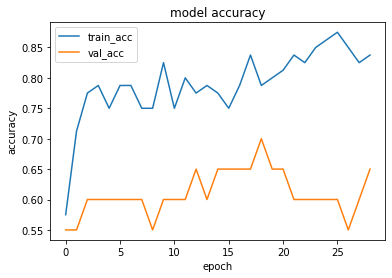

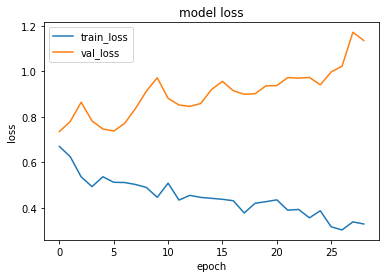

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.88024056]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.9005173]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.93600714]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.23609588]]


1it [00:00, 18641.35it/s]


prediction for video control_2.mov is [[0.05743179]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.11148944]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6785 - accuracy: 0.5250 - precision_15: 0.5217 - recall_15: 0.8780 - val_loss: 0.6639 - val_accuracy: 0.6000 - val_precision_15: 0.5714 - val_recall_15: 0.4444
Epoch 2/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6117 - accuracy: 0.7000 - precision_15: 0.7429 - recall_15: 0.6341 - val_loss: 0.7433 - val_accuracy: 0.6000 - val_precision_15: 0.5455 - val_recall_15: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 356ms/step - loss: 0.5924 - accuracy: 0.7500 - precision_15: 0.7692 - recall_15: 0.7317 - val_loss: 0.8071 - val_accuracy: 0.6000 - val_precision_15: 0.5556 - val_recall_15: 0.5556
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.5090 - accuracy: 0.7375 - precision_15: 0.7174 - recall_15: 0.8049 - val_loss: 0.6910 - val_accuracy: 0.6500 - val_precision_15: 0.6250 - val_recall_15: 0.5556
Epoch 5/75


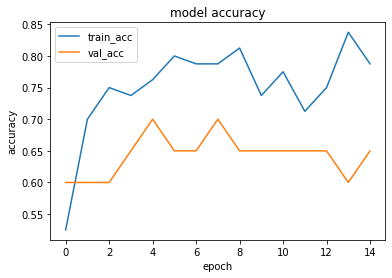

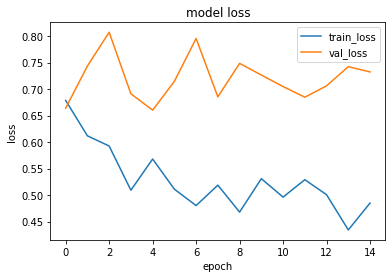

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5554155]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_3.mov is [[0.6730371]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.61774975]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.46258986]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.330086]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.3399158]]
Epoch 1/75
3/3 [==============================] - 1s 329ms/step - loss: 0.6839 - accuracy: 0.5250 - precision_16: 0.5306 - recall_16: 0.6341 - val_loss: 0.6542 - val_accuracy: 0.6500 - val_precision_16: 0.5714 - val_recall_16: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 349ms/step - loss: 0.6465 - accuracy: 0.7500 - precision_16: 0.7234 - recall_16: 0.8293 - val_loss: 0.6056 - val_accuracy: 0.6500 - val_precision_16: 0.5714 - val_recall_16: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6212 - accuracy: 0.7125 - precision_16: 0.6800 - recall_16: 0.8293 - val_loss: 0.5325 - val_accuracy: 0.7000 - val_precision_16: 0.6154 - val_recall_16: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6032 - accuracy: 0.7500 - precision_16: 0.7234 - recall_16: 0.8293 - val_loss: 0.5818 - val_accuracy: 0.6500 - val_precision_16: 0.6667 - val_recall_16: 0.4444
Epoch 5/75
3

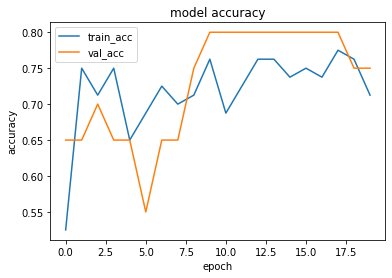

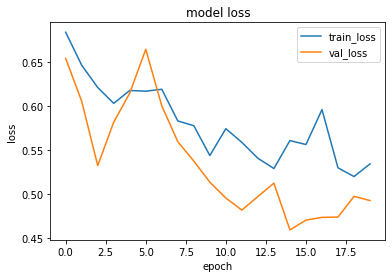

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.65430117]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.82070875]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.7624121]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.20611951]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.19174129]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.18833172]]
Epoch 1/75
3/3 [==============================] - 1s 312ms/step - loss: 0.7373 - accuracy: 0.5000 - precision_17: 0.4643 - recall_17: 0.3421 - val_loss: 0.6604 - val_accuracy: 0.7000 - val_precision_17: 0.7500 - val_recall_17: 0.7500
Epoch 2/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6930 - accuracy: 0.6000 - precision_17: 0.5600 - recall_17: 0.7368 - val_loss: 0.6023 - val_accuracy: 0.7500 - val_precision_17: 0.7333 - val_recall_17: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6463 - accuracy: 0.7125 - precision_17: 0.6744 - recall_17: 0.7632 - val_loss: 0.6408 - val_accuracy: 0.6500 - val_precision_17: 0.8571 - val_recall_17: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6269 - accuracy: 0.7375 - precision_17: 0.8148 - recall_17: 0.5789 - val_loss: 0.5821 - val_accuracy: 0.6500 - val_precision_17: 0.6923 - val_recall_17: 0.7500
Epoch 5/75


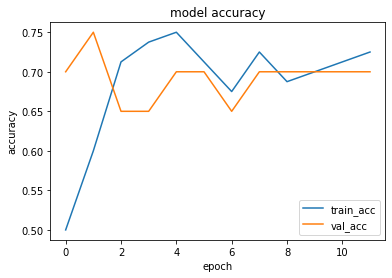

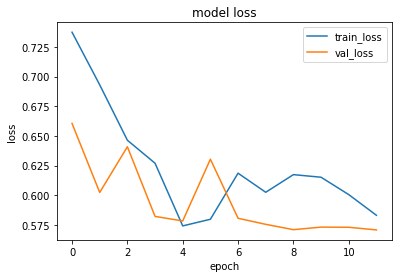

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.4580958]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.53377354]]


1it [00:00, 10754.63it/s]


prediction for video armflapping_2.mov is [[0.551739]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.3929557]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.36765534]]


1it [00:00, 12671.61it/s]


prediction for video control_3.mov is [[0.35809624]]


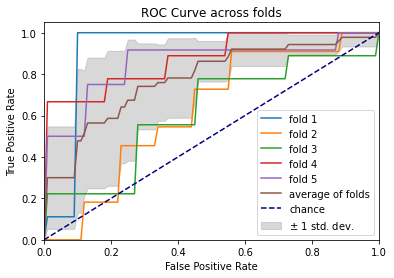

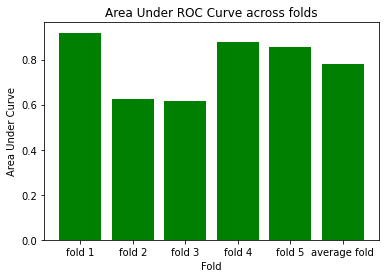

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6962 - accuracy: 0.4125 - precision_19: 0.4400 - recall_19: 0.5366 - val_loss: 0.7618 - val_accuracy: 0.5500 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6726 - accuracy: 0.5875 - precision_19: 0.6538 - recall_19: 0.4146 - val_loss: 0.6268 - val_accuracy: 0.5000 - val_precision_19: 0.4737 - val_recall_19: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6292 - accuracy: 0.5500 - precision_19: 0.5362 - recall_19: 0.9024 - val_loss: 0.5600 - val_accuracy: 0.6500 - val_precision_19: 0.5625 - val_recall_19: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6665 - accuracy: 0.6125 - precision_19: 0.5926 - recall_19: 0.7805 - val_loss: 0.5493 - val_accuracy: 0.9500 - val_precision_19: 0.9000 - val_recall_19: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 303

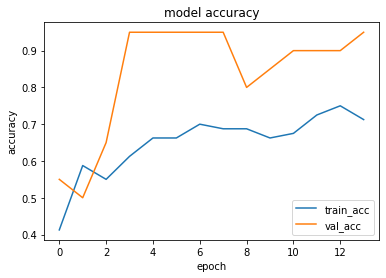

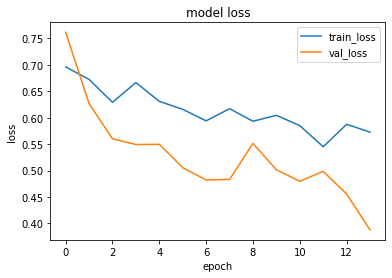

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5129437]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_3.mov is [[0.5165453]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.5387434]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.4792888]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.45841175]]


1it [00:00, 5785.25it/s]


prediction for video control_3.mov is [[0.45659792]]
Epoch 1/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6679 - accuracy: 0.4250 - precision_20: 0.4286 - recall_20: 0.5385 - val_loss: 0.7020 - val_accuracy: 0.6000 - val_precision_20: 0.6364 - val_recall_20: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 408ms/step - loss: 0.5706 - accuracy: 0.7625 - precision_20: 0.7273 - recall_20: 0.8205 - val_loss: 0.8024 - val_accuracy: 0.6000 - val_precision_20: 0.6154 - val_recall_20: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 327ms/step - loss: 0.5937 - accuracy: 0.6500 - precision_20: 0.6122 - recall_20: 0.7692 - val_loss: 0.7518 - val_accuracy: 0.6000 - val_precision_20: 0.6667 - val_recall_20: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 315ms/step - loss: 0.5373 - accuracy: 0.7500 - precision_20: 0.8065 - recall_20: 0.6410 - val_loss: 0.7288 - val_accuracy: 0.6000 - val_precision_20: 0.6364 - val_recall_20: 0.6364
Epoch 5/75


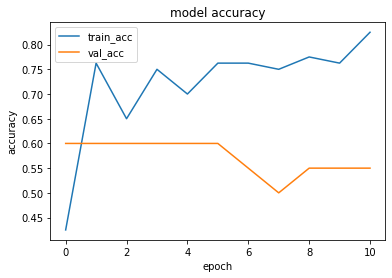

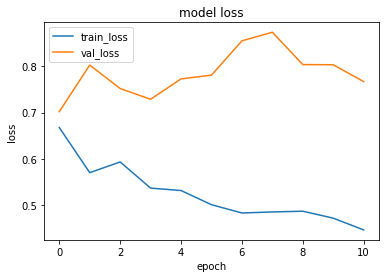

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5284535]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.725356]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.7769668]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.29464737]]


1it [00:00, 19152.07it/s]


prediction for video control_2.mov is [[0.23945642]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.23267654]]
Epoch 1/75
3/3 [==============================] - 1s 313ms/step - loss: 0.7261 - accuracy: 0.5500 - precision_21: 0.5490 - recall_21: 0.6829 - val_loss: 0.7063 - val_accuracy: 0.5000 - val_precision_21: 0.4737 - val_recall_21: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6394 - accuracy: 0.6625 - precision_21: 0.6250 - recall_21: 0.8537 - val_loss: 0.6523 - val_accuracy: 0.6500 - val_precision_21: 0.6667 - val_recall_21: 0.4444
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6287 - accuracy: 0.6875 - precision_21: 0.6818 - recall_21: 0.7317 - val_loss: 0.6560 - val_accuracy: 0.6000 - val_precision_21: 0.5455 - val_recall_21: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 373ms/step - loss: 0.5641 - accuracy: 0.7000 - precision_21: 0.6735 - recall_21: 0.8049 - val_loss: 0.6871 - val_accuracy: 0.6000 - val_precision_21: 0.6667 - val_recall_21: 0.2222
Epoch 5/75


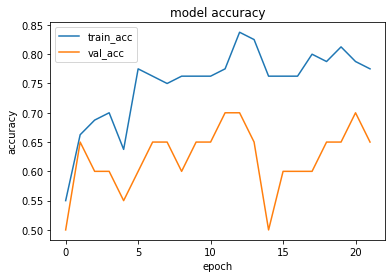

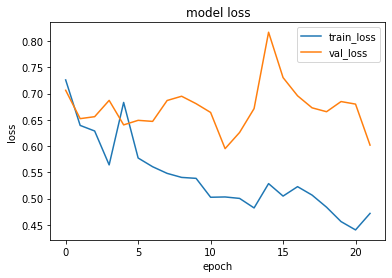

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.38845193]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.62773085]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.78685343]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.29481]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.20629299]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.22945803]]
Epoch 1/75
3/3 [==============================] - 1s 314ms/step - loss: 0.7008 - accuracy: 0.5000 - precision_22: 0.5063 - recall_22: 0.9756 - val_loss: 0.6220 - val_accuracy: 0.7500 - val_precision_22: 1.0000 - val_recall_22: 0.4444
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6858 - accuracy: 0.6125 - precision_22: 0.7500 - recall_22: 0.3659 - val_loss: 0.6362 - val_accuracy: 0.7500 - val_precision_22: 0.6667 - val_recall_22: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6422 - accuracy: 0.7375 - precision_22: 0.7381 - recall_22: 0.7561 - val_loss: 0.6487 - val_accuracy: 0.6000 - val_precision_22: 0.5333 - val_recall_22: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 357ms/step - loss: 0.6404 - accuracy: 0.7375 - precision_22: 0.7083 - recall_22: 0.8293 - val_loss: 0.6534 - val_accuracy: 0.6000 - val_precision_22: 0.5333 - val_recall_22: 0.8889
Epoch 5/75


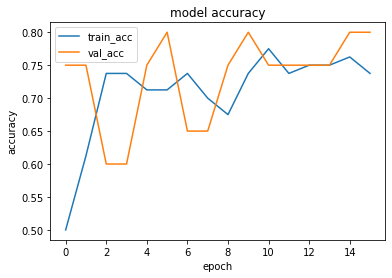

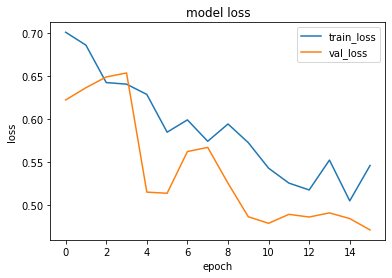

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.34669802]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.5144229]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.6808323]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.21574882]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.18699566]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.18211669]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.7168 - accuracy: 0.5250 - precision_23: 0.5000 - recall_23: 0.3421 - val_loss: 0.6073 - val_accuracy: 0.7500 - val_precision_23: 0.7333 - val_recall_23: 0.9167
Epoch 2/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6479 - accuracy: 0.7000 - precision_23: 0.6591 - recall_23: 0.7632 - val_loss: 0.6002 - val_accuracy: 0.7500 - val_precision_23: 0.8182 - val_recall_23: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6233 - accuracy: 0.6750 - precision_23: 0.6579 - recall_23: 0.6579 - val_loss: 0.6442 - val_accuracy: 0.6000 - val_precision_23: 0.6111 - val_recall_23: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 365ms/step - loss: 0.6660 - accuracy: 0.5875 - precision_23: 0.5385 - recall_23: 0.9211 - val_loss: 0.6052 - val_accuracy: 0.7000 - val_precision_23: 0.6875 - val_recall_23: 0.9167
Epoch 5/75


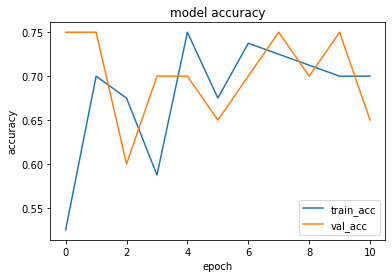

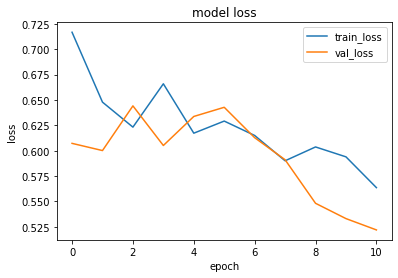

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.50921994]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.65021276]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.6856841]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.30121344]]


1it [00:00, 9446.63it/s]


prediction for video control_2.mov is [[0.24999774]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.23908016]]


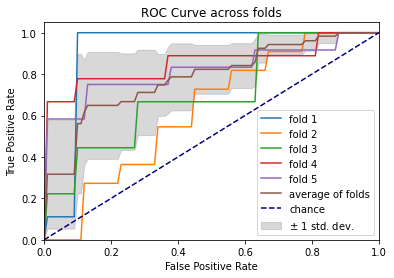

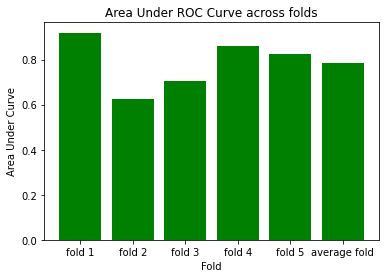

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6795 - accuracy: 0.5875 - precision_25: 0.5909 - recall_25: 0.6341 - val_loss: 0.6029 - val_accuracy: 0.5000 - val_precision_25: 0.4737 - val_recall_25: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6282 - accuracy: 0.6375 - precision_25: 0.6000 - recall_25: 0.8780 - val_loss: 0.5202 - val_accuracy: 0.9000 - val_precision_25: 0.8889 - val_recall_25: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6351 - accuracy: 0.6750 - precision_25: 0.7143 - recall_25: 0.6098 - val_loss: 0.4941 - val_accuracy: 0.9000 - val_precision_25: 0.8889 - val_recall_25: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 300ms/step - loss: 0.5794 - accuracy: 0.7500 - precision_25: 0.8000 - recall_25: 0.6829 - val_loss: 0.4778 - val_accuracy: 0.9000 - val_precision_25: 0.8889 - val_recall_25: 0.8889
Epoch 5/75
3/3 [==============================] - 1s 294ms/step 

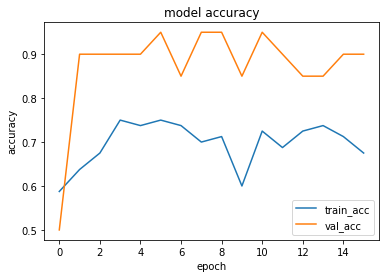

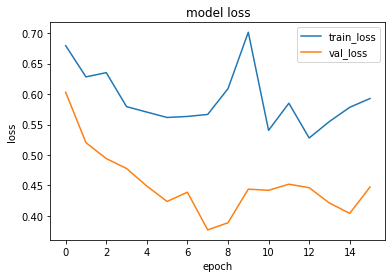

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.5392431]]


1it [00:00, 9341.43it/s]


prediction for video armflapping_3.mov is [[0.5669049]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6330893]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.40705723]]


1it [00:00, 13315.25it/s]


prediction for video control_2.mov is [[0.35717595]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.32706177]]
Epoch 1/75
3/3 [==============================] - 1s 320ms/step - loss: 0.7205 - accuracy: 0.5125 - precision_26: 0.5000 - recall_26: 0.3077 - val_loss: 0.7049 - val_accuracy: 0.5500 - val_precision_26: 0.5500 - val_recall_26: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6509 - accuracy: 0.5875 - precision_26: 0.5455 - recall_26: 0.9231 - val_loss: 0.7181 - val_accuracy: 0.6000 - val_precision_26: 0.6154 - val_recall_26: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 336ms/step - loss: 0.6056 - accuracy: 0.7625 - precision_26: 0.7083 - recall_26: 0.8718 - val_loss: 0.7351 - val_accuracy: 0.6500 - val_precision_26: 0.6429 - val_recall_26: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 311ms/step - loss: 0.5656 - accuracy: 0.7625 - precision_26: 0.7174 - recall_26: 0.8462 - val_loss: 0.7503 - val_accuracy: 0.5000 - val_precision_26: 0.5714 - val_recall_26: 0.3636
Epoch 5/75


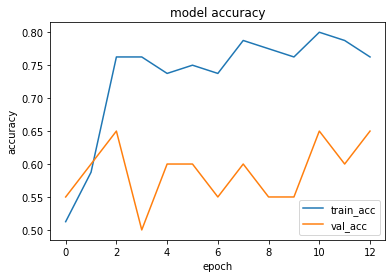

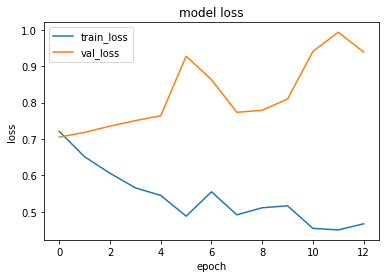

1it [00:00, 16070.13it/s]


prediction for video armflapping_1.mov is [[0.57074594]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.6716536]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.7416873]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.19488394]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.14080337]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.13389665]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6914 - accuracy: 0.5000 - precision_27: 0.5075 - recall_27: 0.8293 - val_loss: 0.6652 - val_accuracy: 0.6000 - val_precision_27: 0.6000 - val_recall_27: 0.3333
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6667 - accuracy: 0.6000 - precision_27: 0.7647 - recall_27: 0.3171 - val_loss: 0.6454 - val_accuracy: 0.6500 - val_precision_27: 0.6667 - val_recall_27: 0.4444
Epoch 3/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6389 - accuracy: 0.7125 - precision_27: 0.7368 - recall_27: 0.6829 - val_loss: 0.6498 - val_accuracy: 0.6500 - val_precision_27: 0.6250 - val_recall_27: 0.5556
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.5890 - accuracy: 0.7250 - precision_27: 0.7021 - recall_27: 0.8049 - val_loss: 0.6472 - val_accuracy: 0.6500 - val_precision_27: 0.6250 - val_recall_27: 0.5556
Epoch 5/75


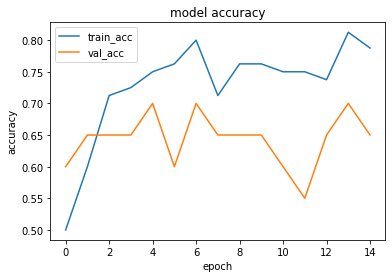

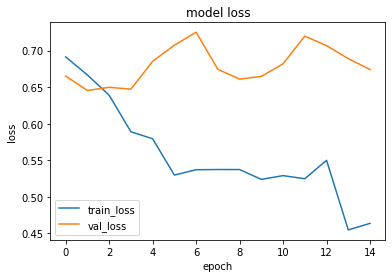

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.47865263]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.6502964]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.75957423]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.22634366]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.18982503]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.186892]]
Epoch 1/75
3/3 [==============================] - 1s 317ms/step - loss: 0.6848 - accuracy: 0.5375 - precision_28: 0.5385 - recall_28: 0.6829 - val_loss: 0.6244 - val_accuracy: 0.6500 - val_precision_28: 0.5714 - val_recall_28: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6444 - accuracy: 0.6625 - precision_28: 0.6400 - recall_28: 0.7805 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_28: 0.6000 - val_recall_28: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6212 - accuracy: 0.6625 - precision_28: 0.6346 - recall_28: 0.8049 - val_loss: 0.5616 - val_accuracy: 0.7500 - val_precision_28: 0.6667 - val_recall_28: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6251 - accuracy: 0.6375 - precision_28: 0.6875 - recall_28: 0.5366 - val_loss: 0.5306 - val_accuracy: 0.9000 - val_precision_28: 0.8889 - val_recall_28: 0.8889
Epoch 5/75
3/

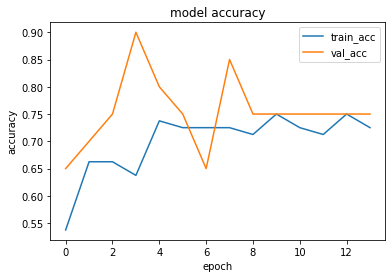

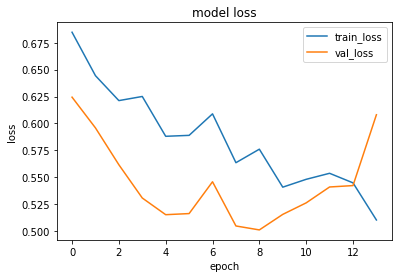

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.67062783]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.87196934]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.85089695]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.33674252]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.2730043]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.18709749]]
Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6894 - accuracy: 0.5875 - precision_29: 0.5472 - recall_29: 0.7632 - val_loss: 0.8130 - val_accuracy: 0.4000 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6965 - accuracy: 0.5500 - precision_29: 0.5833 - recall_29: 0.1842 - val_loss: 0.6095 - val_accuracy: 0.7500 - val_precision_29: 0.7333 - val_recall_29: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6293 - accuracy: 0.6875 - precision_29: 0.6512 - recall_29: 0.7368 - val_loss: 0.5434 - val_accuracy: 0.7000 - val_precision_29: 0.7500 - val_recall_29: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6118 - accuracy: 0.6625 - precision_29: 0.6486 - recall_29: 0.6316 - val_loss: 0.5647 - val_accuracy: 0.7000 - val_precision_29: 0.8750 - val_recall_29: 0.5833
Epo

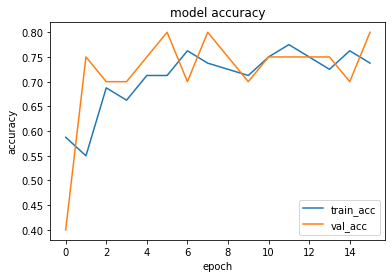

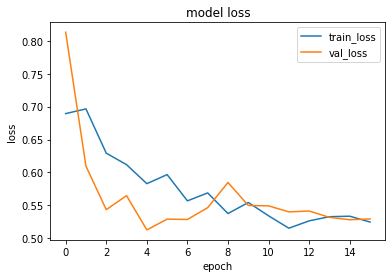

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4524683]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.49329776]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.70078063]]


1it [00:00, 16578.28it/s]


prediction for video control_1.mov is [[0.29699922]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.24742639]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.2485551]]


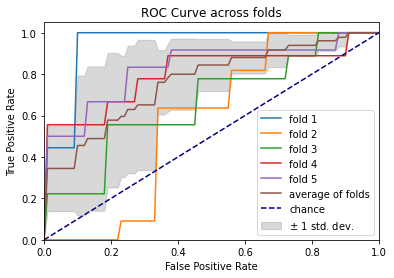

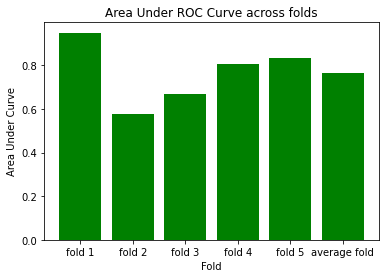

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 363ms/step - loss: 0.7050 - accuracy: 0.4875 - precision_31: 0.5000 - recall_31: 0.3171 - val_loss: 0.6355 - val_accuracy: 0.4500 - val_precision_31: 0.4500 - val_recall_31: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6868 - accuracy: 0.5250 - precision_31: 0.5200 - recall_31: 0.9512 - val_loss: 0.6218 - val_accuracy: 0.9000 - val_precision_31: 0.8182 - val_recall_31: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6580 - accuracy: 0.6000 - precision_31: 0.6552 - recall_31: 0.4634 - val_loss: 0.6615 - val_accuracy: 0.6000 - val_precision_31: 0.6667 - val_recall_31: 0.2222
Epoch 4/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6653 - accuracy: 0.5625 - precision_31: 0.6250 - recall_31: 0.3659 - val_loss: 0.5694 - val_accuracy: 0.9000 - val_precision_31: 0.8182 - val_recall_31: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 354ms/step 

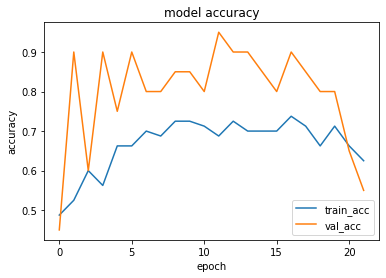

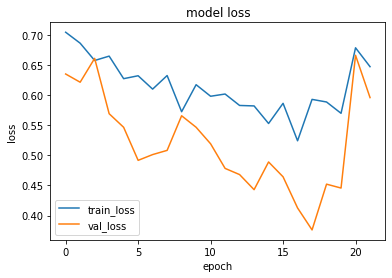

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.5614797]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.49830645]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.65774083]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.45217106]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.43157908]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.4181816]]
Epoch 1/75
3/3 [==============================] - 1s 333ms/step - loss: 0.6804 - accuracy: 0.5250 - precision_32: 0.5106 - recall_32: 0.6154 - val_loss: 0.7134 - val_accuracy: 0.6000 - val_precision_32: 0.6364 - val_recall_32: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 386ms/step - loss: 0.6120 - accuracy: 0.7250 - precision_32: 0.7179 - recall_32: 0.7179 - val_loss: 0.7561 - val_accuracy: 0.4000 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6012 - accuracy: 0.6625 - precision_32: 0.7000 - recall_32: 0.5385 - val_loss: 0.8533 - val_accuracy: 0.5000 - val_precision_32: 0.5556 - val_recall_32: 0.4545
Epoch 4/75
3/3 [==============================] - 1s 313ms/step - loss: 0.5516 - accuracy: 0.7500 - precision_32: 0.7111 - recall_32: 0.8205 - val_loss: 0.7786 - val_accuracy: 0.5000 - val_precision_32: 0.5556 - val_recall_32: 0.4545
Epoc

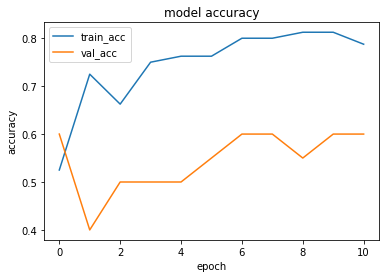

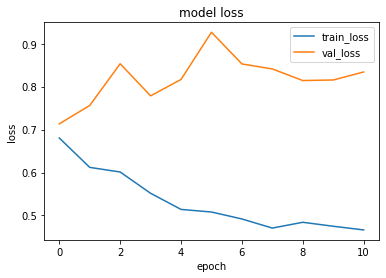

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.5869722]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.7286271]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.74967694]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.21631485]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.19188607]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.18928325]]
Epoch 1/75
3/3 [==============================] - 1s 386ms/step - loss: 0.6792 - accuracy: 0.5375 - precision_33: 0.5400 - recall_33: 0.6585 - val_loss: 0.6894 - val_accuracy: 0.6500 - val_precision_33: 0.6000 - val_recall_33: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6230 - accuracy: 0.7625 - precision_33: 0.7500 - recall_33: 0.8049 - val_loss: 0.6890 - val_accuracy: 0.6000 - val_precision_33: 0.5556 - val_recall_33: 0.5556
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.5318 - accuracy: 0.7875 - precision_33: 0.7727 - recall_33: 0.8293 - val_loss: 0.7581 - val_accuracy: 0.6500 - val_precision_33: 0.6667 - val_recall_33: 0.4444
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.5754 - accuracy: 0.7500 - precision_33: 0.7234 - recall_33: 0.8293 - val_loss: 0.8080 - val_accuracy: 0.6000 - val_precision_33: 0.5714 - val_recall_33: 0.4444
Epoch 5/75


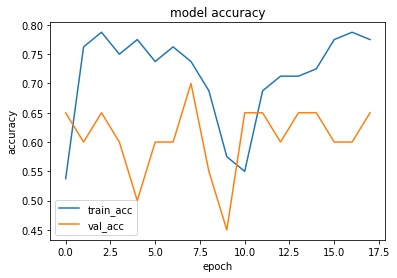

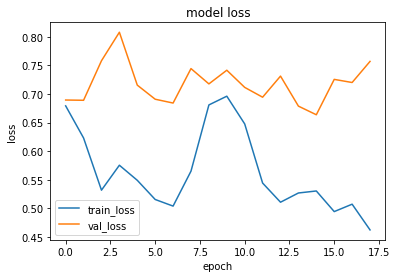

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.6333223]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.8197509]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.78456736]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.24487916]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.2303293]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.22640482]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.7327 - accuracy: 0.4375 - precision_34: 0.4167 - recall_34: 0.2439 - val_loss: 0.7899 - val_accuracy: 0.4500 - val_precision_34: 0.4500 - val_recall_34: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.7852 - accuracy: 0.5500 - precision_34: 0.5325 - recall_34: 1.0000 - val_loss: 0.7735 - val_accuracy: 0.5500 - val_precision_34: 0.5000 - val_recall_34: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6702 - accuracy: 0.6625 - precision_34: 0.6522 - recall_34: 0.7317 - val_loss: 0.6882 - val_accuracy: 0.6000 - val_precision_34: 0.5385 - val_recall_34: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 366ms/step - loss: 0.6611 - accuracy: 0.6625 - precision_34: 0.6750 - recall_34: 0.6585 - val_loss: 0.6579 - val_accuracy: 0.7000 - val_precision_34: 0.6364 - val_recall_34: 0.7778
Epoch 5/75


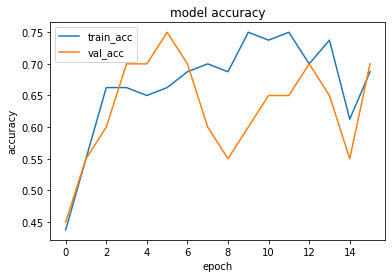

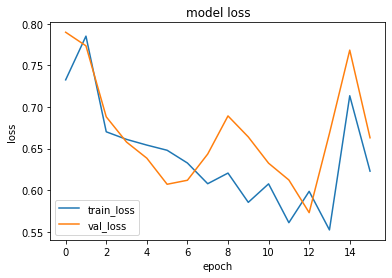

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.60916376]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.58093566]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.56222475]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.6105839]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.613028]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.17200458]]
Epoch 1/75
3/3 [==============================] - 1s 319ms/step - loss: 0.8052 - accuracy: 0.4125 - precision_35: 0.4237 - recall_35: 0.6579 - val_loss: 0.6492 - val_accuracy: 0.7500 - val_precision_35: 0.7333 - val_recall_35: 0.9167
Epoch 2/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6843 - accuracy: 0.6375 - precision_35: 0.6286 - recall_35: 0.5789 - val_loss: 0.6627 - val_accuracy: 0.7000 - val_precision_35: 1.0000 - val_recall_35: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6596 - accuracy: 0.6750 - precision_35: 0.7500 - recall_35: 0.4737 - val_loss: 0.6236 - val_accuracy: 0.8000 - val_precision_35: 0.8333 - val_recall_35: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6065 - accuracy: 0.7750 - precision_35: 0.7381 - recall_35: 0.8158 - val_loss: 0.6197 - val_accuracy: 0.7000 - val_precision_35: 0.7143 - val_recall_35: 0.8333
Epoch 5/75


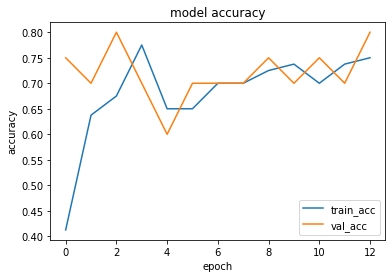

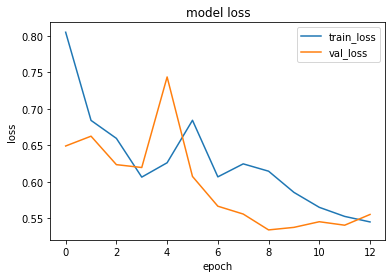

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.25889176]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.6459417]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.67014337]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.25452042]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.2531798]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.2527095]]


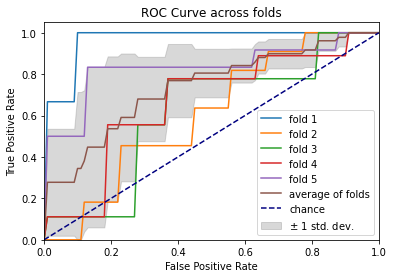

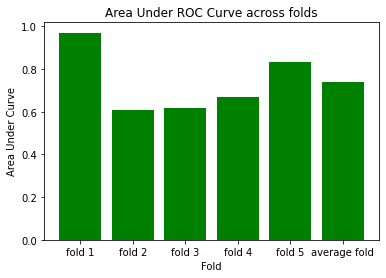

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6967 - accuracy: 0.5375 - precision_37: 0.5588 - recall_37: 0.4634 - val_loss: 0.6483 - val_accuracy: 0.5000 - val_precision_37: 0.4737 - val_recall_37: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6683 - accuracy: 0.5500 - precision_37: 0.5333 - recall_37: 0.9756 - val_loss: 0.6280 - val_accuracy: 0.5000 - val_precision_37: 0.4737 - val_recall_37: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6558 - accuracy: 0.5875 - precision_37: 0.5571 - recall_37: 0.9512 - val_loss: 0.5639 - val_accuracy: 0.5000 - val_precision_37: 0.4737 - val_recall_37: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6294 - accuracy: 0.6000 - precision_37: 0.5849 - recall_37: 0.7561 - val_loss: 0.5111 - val_accuracy: 0.9500 - val_precision_37: 0.9000 - val_recall_37: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 301ms/step 

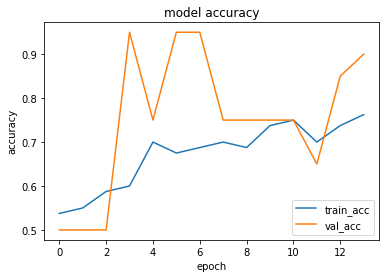

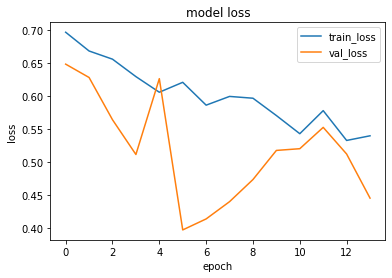

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.52117795]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.54062325]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6157474]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.48357266]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4668333]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.46391544]]
Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6781 - accuracy: 0.6125 - precision_38: 0.6053 - recall_38: 0.5897 - val_loss: 0.6915 - val_accuracy: 0.6500 - val_precision_38: 0.6667 - val_recall_38: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6050 - accuracy: 0.6875 - precision_38: 0.6346 - recall_38: 0.8462 - val_loss: 0.7131 - val_accuracy: 0.6000 - val_precision_38: 0.6364 - val_recall_38: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 326ms/step - loss: 0.5542 - accuracy: 0.7500 - precision_38: 0.7436 - recall_38: 0.7436 - val_loss: 0.7187 - val_accuracy: 0.6000 - val_precision_38: 0.6364 - val_recall_38: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 357ms/step - loss: 0.5416 - accuracy: 0.7500 - precision_38: 0.7436 - recall_38: 0.7436 - val_loss: 0.8626 - val_accuracy: 0.6000 - val_precision_38: 0.6364 - val_recall_38: 0.6364
Epoch 5/75


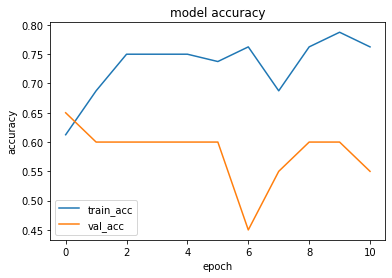

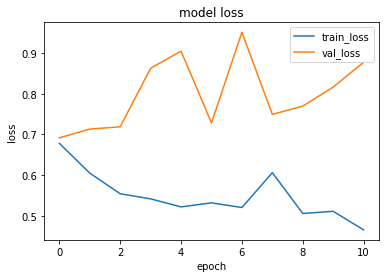

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.32272846]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_3.mov is [[0.50782037]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.6791295]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.14752981]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.12083337]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.11671841]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6861 - accuracy: 0.5250 - precision_39: 0.5254 - recall_39: 0.7561 - val_loss: 0.6933 - val_accuracy: 0.5500 - val_precision_39: 0.5000 - val_recall_39: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 365ms/step - loss: 0.6286 - accuracy: 0.7125 - precision_39: 0.6957 - recall_39: 0.7805 - val_loss: 0.6503 - val_accuracy: 0.7000 - val_precision_39: 0.7143 - val_recall_39: 0.5556
Epoch 3/75
3/3 [==============================] - 1s 300ms/step - loss: 0.5974 - accuracy: 0.7500 - precision_39: 0.7333 - recall_39: 0.8049 - val_loss: 0.6949 - val_accuracy: 0.6500 - val_precision_39: 0.6000 - val_recall_39: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.5525 - accuracy: 0.7625 - precision_39: 0.7391 - recall_39: 0.8293 - val_loss: 0.6825 - val_accuracy: 0.6500 - val_precision_39: 0.7500 - val_recall_39: 0.3333
Epoch 5/75


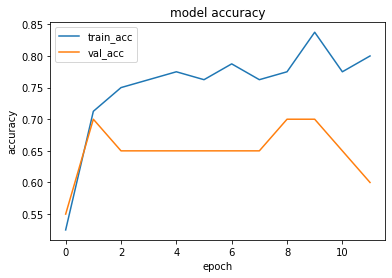

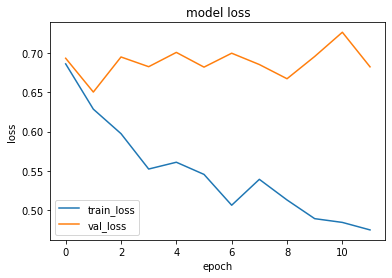

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.47896692]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.4193784]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5703949]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.35137713]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.29987496]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.3014956]]
Epoch 1/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6855 - accuracy: 0.6000 - precision_40: 0.5763 - recall_40: 0.8293 - val_loss: 0.6448 - val_accuracy: 0.7000 - val_precision_40: 0.6154 - val_recall_40: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6616 - accuracy: 0.6625 - precision_40: 0.7188 - recall_40: 0.5610 - val_loss: 0.6246 - val_accuracy: 0.7000 - val_precision_40: 0.6154 - val_recall_40: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6286 - accuracy: 0.7125 - precision_40: 0.7143 - recall_40: 0.7317 - val_loss: 0.6433 - val_accuracy: 0.6000 - val_precision_40: 0.5333 - val_recall_40: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6620 - accuracy: 0.7000 - precision_40: 0.6889 - recall_40: 0.7561 - val_loss: 0.5322 - val_accuracy: 0.7000 - val_precision_40: 0.6154 - val_recall_40: 0.8889
Epoch 5/75
3

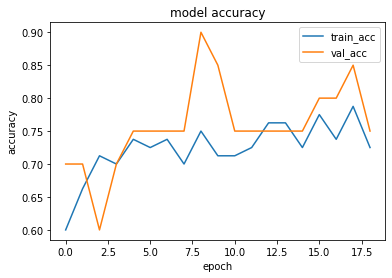

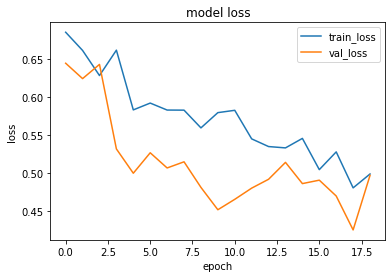

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.6022144]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.6582022]]


1it [00:00, 10951.19it/s]


prediction for video armflapping_2.mov is [[0.7184931]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.2945243]]


1it [00:00, 16320.25it/s]


prediction for video control_2.mov is [[0.21900162]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.20626315]]
Epoch 1/75
3/3 [==============================] - 1s 326ms/step - loss: 0.6764 - accuracy: 0.5625 - precision_41: 0.5405 - recall_41: 0.5263 - val_loss: 0.6005 - val_accuracy: 0.7500 - val_precision_41: 0.7692 - val_recall_41: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6452 - accuracy: 0.6500 - precision_41: 0.7083 - recall_41: 0.4474 - val_loss: 0.5581 - val_accuracy: 0.7500 - val_precision_41: 0.7692 - val_recall_41: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6097 - accuracy: 0.7375 - precision_41: 0.7429 - recall_41: 0.6842 - val_loss: 0.5517 - val_accuracy: 0.7000 - val_precision_41: 0.6875 - val_recall_41: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.5783 - accuracy: 0.7125 - precision_41: 0.6923 - recall_41: 0.7105 - val_loss: 0.5223 - val_accuracy: 0.8000 - val_precision_41: 0.9000 - val_recall_41: 0.7500
Epoch 5/75


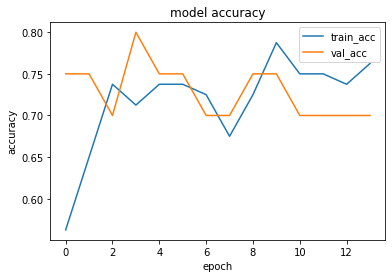

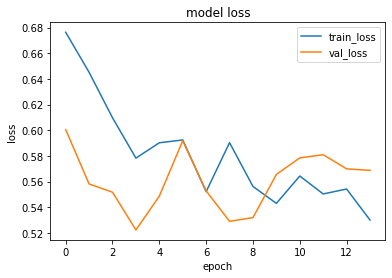

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.68139744]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.88683766]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.81089866]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.40249273]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.29241788]]


1it [00:00, 18641.35it/s]

prediction for video control_3.mov is [[0.32744178]]


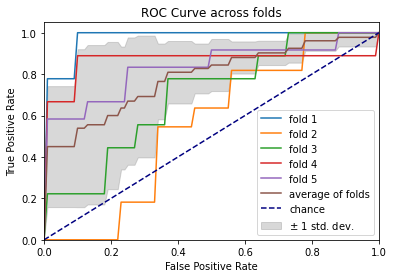

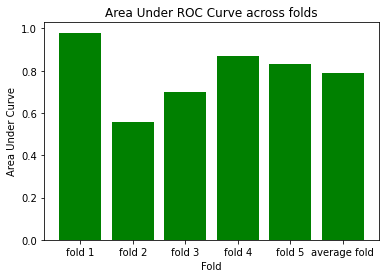

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6911 - accuracy: 0.5125 - precision_43: 0.5172 - recall_43: 0.7317 - val_loss: 0.8339 - val_accuracy: 0.5500 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.7156 - accuracy: 0.5500 - precision_43: 0.6316 - recall_43: 0.2927 - val_loss: 0.6527 - val_accuracy: 0.4000 - val_precision_43: 0.4118 - val_recall_43: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6406 - accuracy: 0.6000 - precision_43: 0.5714 - recall_43: 0.8780 - val_loss: 0.5752 - val_accuracy: 0.9500 - val_precision_43: 0.9000 - val_recall_43: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6189 - accuracy: 0.6750 - precision_43: 0.6596 - recall_43: 0.7561 - val_loss: 0.5232 - val_accuracy: 0.9000 - val_precision_43: 0.8889 - val_recall_43: 0.8889
Epoch 5/75
3/3 [==============================] - 1s 354

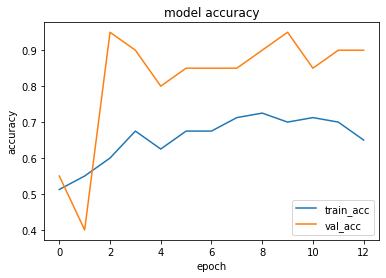

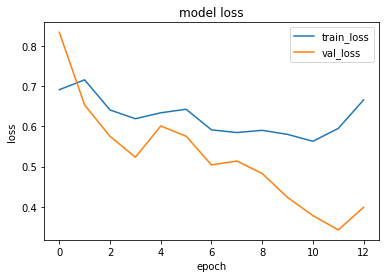

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.5138355]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.50774753]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.55989987]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.4758236]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.458515]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.44961047]]
Epoch 1/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6784 - accuracy: 0.5875 - precision_44: 0.5625 - recall_44: 0.6923 - val_loss: 0.7015 - val_accuracy: 0.5000 - val_precision_44: 0.5556 - val_recall_44: 0.4545
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.5807 - accuracy: 0.7500 - precision_44: 0.7317 - recall_44: 0.7692 - val_loss: 0.7474 - val_accuracy: 0.5500 - val_precision_44: 0.6250 - val_recall_44: 0.4545
Epoch 3/75
3/3 [==============================] - 1s 307ms/step - loss: 0.5665 - accuracy: 0.7625 - precision_44: 0.7778 - recall_44: 0.7179 - val_loss: 0.7346 - val_accuracy: 0.6000 - val_precision_44: 0.6364 - val_recall_44: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 311ms/step - loss: 0.5074 - accuracy: 0.7750 - precision_44: 0.8182 - recall_44: 0.6923 - val_loss: 0.8021 - val_accuracy: 0.6000 - val_precision_44: 0.6667 - val_recall_44: 0.5455
Epoch 5/75


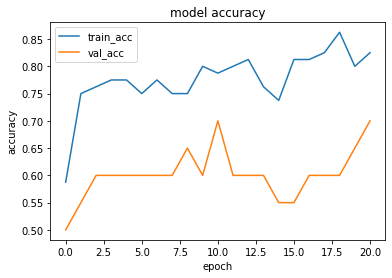

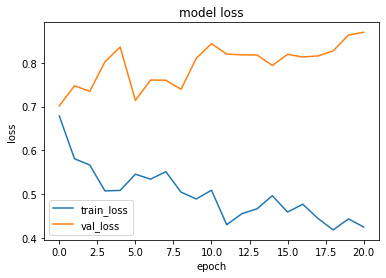

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.3880694]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5191743]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.73360395]]


1it [00:00, 12826.62it/s]


prediction for video control_1.mov is [[0.1471689]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.13508233]]


1it [00:00, 17050.02it/s]


prediction for video control_3.mov is [[0.13191172]]
Epoch 1/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6874 - accuracy: 0.5625 - precision_45: 0.5750 - recall_45: 0.5610 - val_loss: 0.7145 - val_accuracy: 0.5000 - val_precision_45: 0.4737 - val_recall_45: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6560 - accuracy: 0.6375 - precision_45: 0.6200 - recall_45: 0.7561 - val_loss: 0.6613 - val_accuracy: 0.6000 - val_precision_45: 0.5556 - val_recall_45: 0.5556
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.5841 - accuracy: 0.7375 - precision_45: 0.7632 - recall_45: 0.7073 - val_loss: 0.6813 - val_accuracy: 0.6500 - val_precision_45: 0.6250 - val_recall_45: 0.5556
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.5157 - accuracy: 0.7500 - precision_45: 0.7333 - recall_45: 0.8049 - val_loss: 0.7808 - val_accuracy: 0.6000 - val_precision_45: 0.6667 - val_recall_45: 0.2222
Epoch 5/75


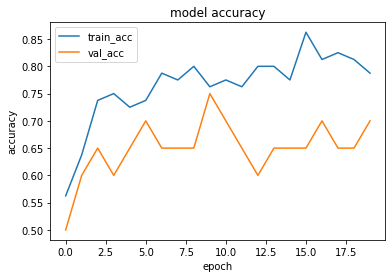

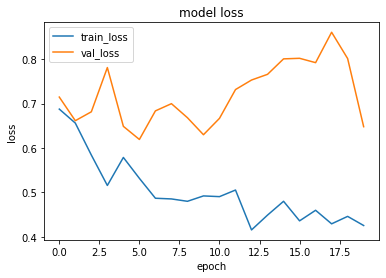

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.61922264]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.684569]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.7529439]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.43846878]]


1it [00:00, 14027.77it/s]


prediction for video control_2.mov is [[0.28537804]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.28944838]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6872 - accuracy: 0.5625 - precision_46: 0.5517 - recall_46: 0.7805 - val_loss: 0.5935 - val_accuracy: 0.7000 - val_precision_46: 0.6154 - val_recall_46: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6665 - accuracy: 0.6875 - precision_46: 0.6538 - recall_46: 0.8293 - val_loss: 0.6292 - val_accuracy: 0.6500 - val_precision_46: 0.6000 - val_recall_46: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 347ms/step - loss: 0.6400 - accuracy: 0.6875 - precision_46: 0.7222 - recall_46: 0.6341 - val_loss: 0.6081 - val_accuracy: 0.8500 - val_precision_46: 1.0000 - val_recall_46: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6505 - accuracy: 0.6500 - precision_46: 0.6857 - recall_46: 0.5854 - val_loss: 0.5794 - val_accuracy: 0.7000 - val_precision_46: 0.6364 - val_recall_46: 0.7778
Epoch 5/75


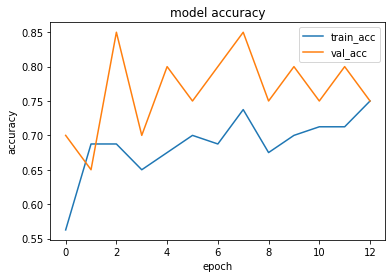

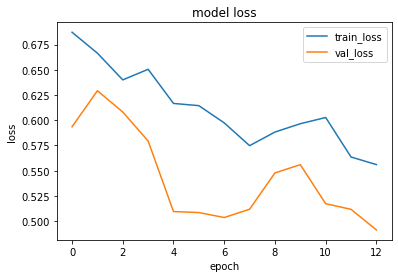

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.58568305]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6433473]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.69488704]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.49560833]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.3475188]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.4045512]]
Epoch 1/75
3/3 [==============================] - 1s 308ms/step - loss: 0.7162 - accuracy: 0.5625 - precision_47: 0.5714 - recall_47: 0.3158 - val_loss: 0.6158 - val_accuracy: 0.7000 - val_precision_47: 0.6667 - val_recall_47: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6700 - accuracy: 0.5875 - precision_47: 0.5410 - recall_47: 0.8684 - val_loss: 0.5951 - val_accuracy: 0.8000 - val_precision_47: 0.7857 - val_recall_47: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6371 - accuracy: 0.7125 - precision_47: 0.7143 - recall_47: 0.6579 - val_loss: 0.5861 - val_accuracy: 0.8000 - val_precision_47: 1.0000 - val_recall_47: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 291ms/step - loss: 0.5827 - accuracy: 0.6875 - precision_47: 0.6857 - recall_47: 0.6316 - val_loss: 0.5538 - val_accuracy: 0.7000 - val_precision_47: 0.6875 - val_recall_47: 0.9167
Epoch 5/75
3

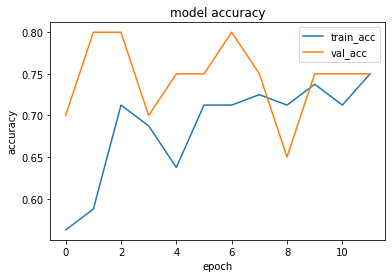

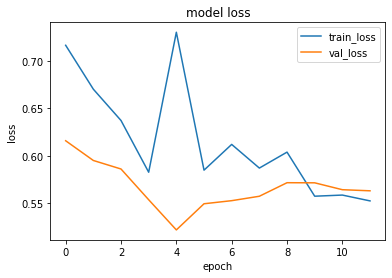

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.29531962]]


1it [00:00, 11650.84it/s]


prediction for video armflapping_3.mov is [[0.46626893]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.6265441]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.28494036]]


1it [00:00, 11491.24it/s]


prediction for video control_2.mov is [[0.24865103]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.23482382]]


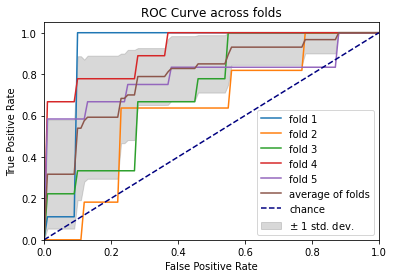

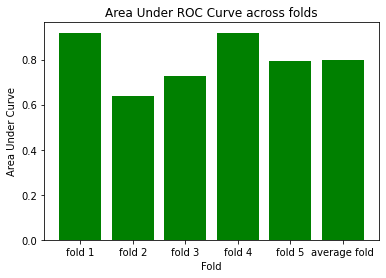

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6970 - accuracy: 0.5250 - precision_49: 0.5714 - recall_49: 0.2927 - val_loss: 0.6151 - val_accuracy: 0.5000 - val_precision_49: 0.4737 - val_recall_49: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6868 - accuracy: 0.5875 - precision_49: 0.5541 - recall_49: 1.0000 - val_loss: 0.6198 - val_accuracy: 0.5500 - val_precision_49: 0.5000 - val_recall_49: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6319 - accuracy: 0.6250 - precision_49: 0.5965 - recall_49: 0.8293 - val_loss: 0.6500 - val_accuracy: 0.7500 - val_precision_49: 0.8333 - val_recall_49: 0.5556
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6439 - accuracy: 0.6750 - precision_49: 0.7586 - recall_49: 0.5366 - val_loss: 0.6788 - val_accuracy: 0.7000 - val_precision_49: 1.0000 - val_recall_49: 0.3333
Epoch 5/75
3/3 [==============================] - 1s 342ms/step 

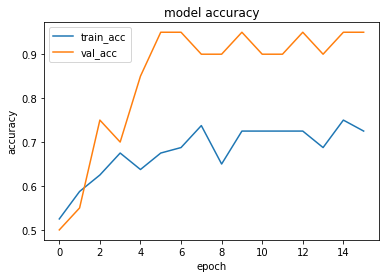

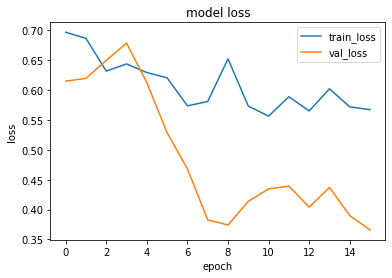

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5332706]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.563463]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5958143]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.4741853]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.4496457]]


1it [00:00, 12052.60it/s]


prediction for video control_3.mov is [[0.42694452]]
Epoch 1/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6664 - accuracy: 0.6375 - precision_50: 0.6786 - recall_50: 0.4872 - val_loss: 0.7058 - val_accuracy: 0.6000 - val_precision_50: 0.6364 - val_recall_50: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6543 - accuracy: 0.6000 - precision_50: 0.5636 - recall_50: 0.7949 - val_loss: 0.7300 - val_accuracy: 0.6000 - val_precision_50: 0.6364 - val_recall_50: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 310ms/step - loss: 0.5508 - accuracy: 0.7750 - precision_50: 0.7692 - recall_50: 0.7692 - val_loss: 0.7285 - val_accuracy: 0.5000 - val_precision_50: 0.6000 - val_recall_50: 0.2727
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6256 - accuracy: 0.6500 - precision_50: 0.8235 - recall_50: 0.3590 - val_loss: 0.7383 - val_accuracy: 0.5000 - val_precision_50: 0.6000 - val_recall_50: 0.2727
Epoch 5/75


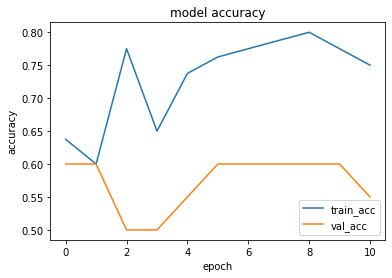

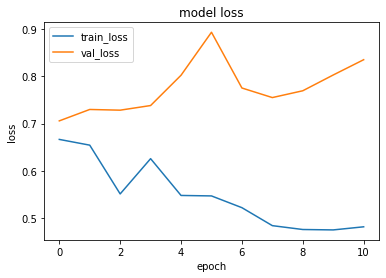

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.2873511]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.51079905]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.71888405]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.22087264]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.20716935]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.20215544]]
Epoch 1/75
3/3 [==============================] - 1s 296ms/step - loss: 0.7219 - accuracy: 0.5000 - precision_51: 0.5065 - recall_51: 0.9512 - val_loss: 0.6717 - val_accuracy: 0.5000 - val_precision_51: 0.4000 - val_recall_51: 0.2222
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7035 - accuracy: 0.5500 - precision_51: 0.7273 - recall_51: 0.1951 - val_loss: 0.6744 - val_accuracy: 0.5000 - val_precision_51: 0.4000 - val_recall_51: 0.2222
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6520 - accuracy: 0.6750 - precision_51: 0.7586 - recall_51: 0.5366 - val_loss: 0.6806 - val_accuracy: 0.6000 - val_precision_51: 0.5455 - val_recall_51: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 348ms/step - loss: 0.6088 - accuracy: 0.7125 - precision_51: 0.6667 - recall_51: 0.8780 - val_loss: 0.8462 - val_accuracy: 0.5500 - val_precision_51: 0.5000 - val_recall_51: 0.4444
Epoch 5/75


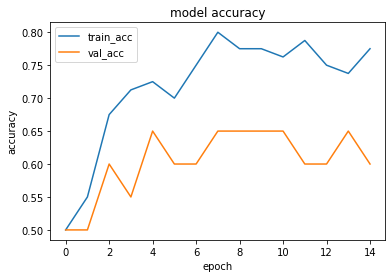

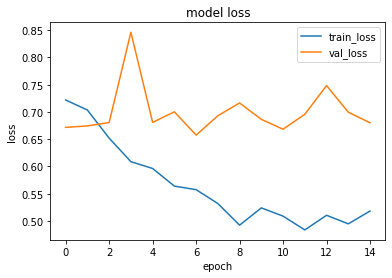

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.49337143]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.6010897]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6672873]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.35108477]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.26392105]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.26388794]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6657 - accuracy: 0.6000 - precision_52: 0.5714 - recall_52: 0.8780 - val_loss: 0.5568 - val_accuracy: 0.7500 - val_precision_52: 0.6667 - val_recall_52: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 292ms/step - loss: 0.7222 - accuracy: 0.5750 - precision_52: 0.6129 - recall_52: 0.4634 - val_loss: 0.5526 - val_accuracy: 0.8500 - val_precision_52: 0.8000 - val_recall_52: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6310 - accuracy: 0.7625 - precision_52: 0.7391 - recall_52: 0.8293 - val_loss: 0.6272 - val_accuracy: 0.6000 - val_precision_52: 0.5333 - val_recall_52: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 345ms/step - loss: 0.6238 - accuracy: 0.6750 - precision_52: 0.6471 - recall_52: 0.8049 - val_loss: 0.5888 - val_accuracy: 0.6500 - val_precision_52: 0.5714 - val_recall_52: 0.8889
Epoch 5/75


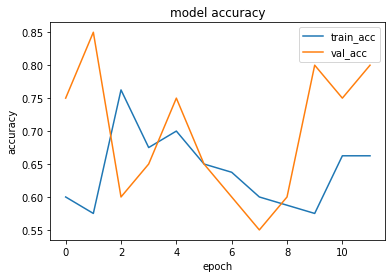

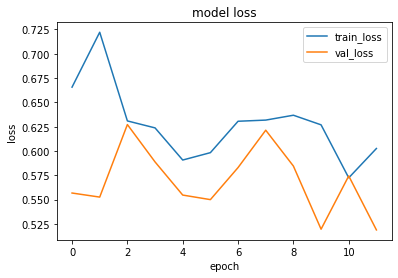

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.37056863]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.53565294]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.43697405]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.34271002]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.33196127]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.33345672]]
Epoch 1/75
3/3 [==============================] - 1s 312ms/step - loss: 0.7243 - accuracy: 0.4500 - precision_53: 0.4211 - recall_53: 0.4211 - val_loss: 0.6523 - val_accuracy: 0.7500 - val_precision_53: 0.7692 - val_recall_53: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6688 - accuracy: 0.6875 - precision_53: 0.6275 - recall_53: 0.8421 - val_loss: 0.5939 - val_accuracy: 0.7000 - val_precision_53: 0.7143 - val_recall_53: 0.8333
Epoch 3/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6368 - accuracy: 0.7250 - precision_53: 0.6739 - recall_53: 0.8158 - val_loss: 0.5489 - val_accuracy: 0.8000 - val_precision_53: 0.8333 - val_recall_53: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 289ms/step - loss: 0.5817 - accuracy: 0.6875 - precision_53: 0.6585 - recall_53: 0.7105 - val_loss: 0.8277 - val_accuracy: 0.6000 - val_precision_53: 0.6667 - val_recall_53: 0.6667
Epoch 5/75


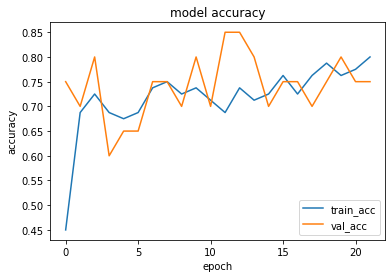

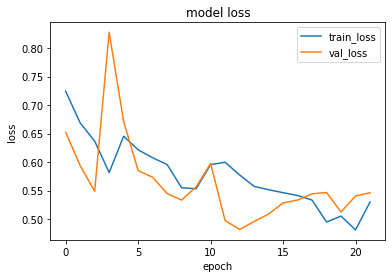

1it [00:00, 14563.56it/s]


prediction for video armflapping_1.mov is [[0.32359684]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.68258023]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.7819245]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.2797289]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.2759018]]


1it [00:00, 19691.57it/s]

prediction for video control_3.mov is [[0.27489018]]


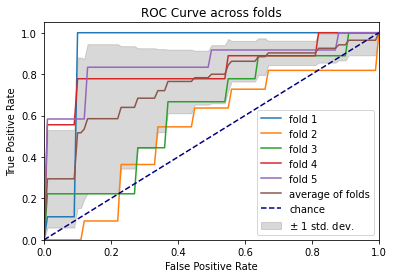

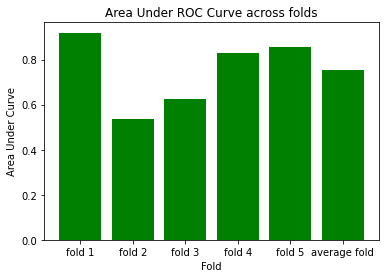

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 376ms/step - loss: 0.6665 - accuracy: 0.4750 - precision_55: 0.4909 - recall_55: 0.6585 - val_loss: 0.6069 - val_accuracy: 0.6500 - val_precision_55: 0.5625 - val_recall_55: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 339ms/step - loss: 0.7629 - accuracy: 0.6875 - precision_55: 0.6333 - recall_55: 0.9268 - val_loss: 0.7304 - val_accuracy: 0.5500 - val_precision_55: 0.0000e+00 - val_recall_55: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6817 - accuracy: 0.5875 - precision_55: 0.8333 - recall_55: 0.2439 - val_loss: 0.7474 - val_accuracy: 0.5500 - val_precision_55: 0.0000e+00 - val_recall_55: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6439 - accuracy: 0.6125 - precision_55: 0.7500 - recall_55: 0.3659 - val_loss: 0.6676 - val_accuracy: 0.7000 - val_precision_55: 0.8000 - val_recall_55: 0.4444
Epoch 5/75
3/3 [==============================] 

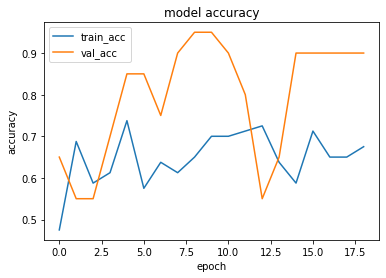

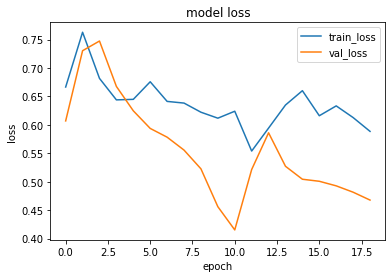

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5345346]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.47885877]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5835426]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.48343366]]


1it [00:00, 19508.39it/s]


prediction for video control_2.mov is [[0.4387619]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.43709868]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6589 - accuracy: 0.5500 - precision_56: 0.5238 - recall_56: 0.8462 - val_loss: 0.7629 - val_accuracy: 0.4500 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 352ms/step - loss: 0.6995 - accuracy: 0.6375 - precision_56: 0.7500 - recall_56: 0.3846 - val_loss: 0.7361 - val_accuracy: 0.5000 - val_precision_56: 0.5556 - val_recall_56: 0.4545
Epoch 3/75
3/3 [==============================] - 1s 308ms/step - loss: 0.5863 - accuracy: 0.7875 - precision_56: 0.7500 - recall_56: 0.8462 - val_loss: 0.7453 - val_accuracy: 0.6000 - val_precision_56: 0.6364 - val_recall_56: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.5569 - accuracy: 0.7625 - precision_56: 0.7174 - recall_56: 0.8462 - val_loss: 0.7376 - val_accuracy: 0.5000 - val_precision_56: 0.5556 - val_recall_56: 0.4545
Epo

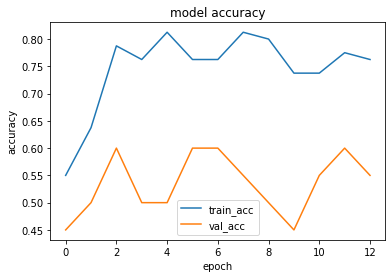

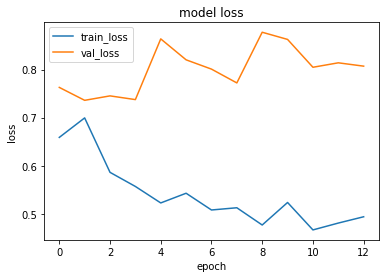

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.45670572]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5091676]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.7509748]]


1it [00:00, 23301.69it/s]


prediction for video control_1.mov is [[0.29415554]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.26949066]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.20883793]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6637 - accuracy: 0.6125 - precision_57: 0.5962 - recall_57: 0.7561 - val_loss: 0.8748 - val_accuracy: 0.5500 - val_precision_57: 0.5000 - val_recall_57: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6597 - accuracy: 0.6375 - precision_57: 0.6111 - recall_57: 0.8049 - val_loss: 0.6368 - val_accuracy: 0.6500 - val_precision_57: 0.6667 - val_recall_57: 0.4444
Epoch 3/75
3/3 [==============================] - 1s 348ms/step - loss: 0.6627 - accuracy: 0.6875 - precision_57: 0.7857 - recall_57: 0.5366 - val_loss: 0.6964 - val_accuracy: 0.6000 - val_precision_57: 0.5556 - val_recall_57: 0.5556
Epoch 4/75
3/3 [==============================] - 1s 287ms/step - loss: 0.5820 - accuracy: 0.7375 - precision_57: 0.7500 - recall_57: 0.7317 - val_loss: 0.7728 - val_accuracy: 0.5500 - val_precision_57: 0.5000 - val_recall_57: 0.5556
Epoch 5/75


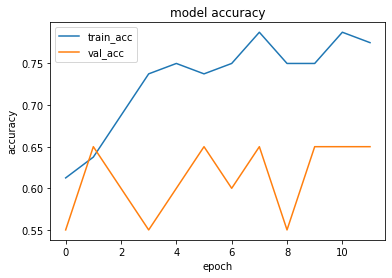

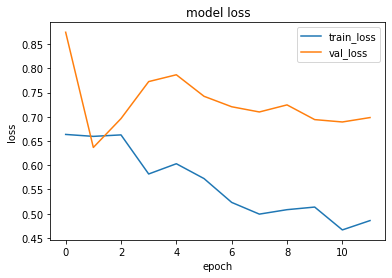

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5435693]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.64549905]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.7626821]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.36203226]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.2804445]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.25504172]]
Epoch 1/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6773 - accuracy: 0.5125 - precision_58: 0.5192 - recall_58: 0.6585 - val_loss: 0.5790 - val_accuracy: 0.6000 - val_precision_58: 0.5385 - val_recall_58: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6602 - accuracy: 0.5875 - precision_58: 0.6053 - recall_58: 0.5610 - val_loss: 0.5660 - val_accuracy: 0.8000 - val_precision_58: 0.7778 - val_recall_58: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6439 - accuracy: 0.7000 - precision_58: 0.6889 - recall_58: 0.7561 - val_loss: 0.5820 - val_accuracy: 0.6500 - val_precision_58: 0.5714 - val_recall_58: 0.8889
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6377 - accuracy: 0.7125 - precision_58: 0.6800 - recall_58: 0.8293 - val_loss: 0.5748 - val_accuracy: 0.6500 - val_precision_58: 0.5714 - val_recall_58: 0.8889
Epoch 5/75


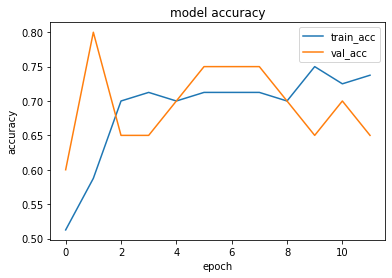

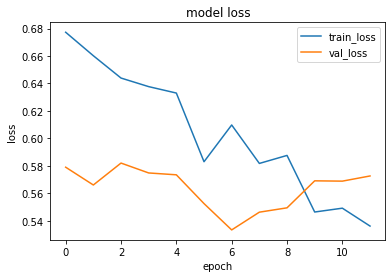

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.44790408]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.6374947]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.85035837]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.30298352]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.2489146]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.24822906]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.7081 - accuracy: 0.3375 - precision_59: 0.3256 - recall_59: 0.3684 - val_loss: 0.5943 - val_accuracy: 0.6500 - val_precision_59: 0.6316 - val_recall_59: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6847 - accuracy: 0.6000 - precision_59: 0.5556 - recall_59: 0.7895 - val_loss: 0.6168 - val_accuracy: 0.7000 - val_precision_59: 0.8750 - val_recall_59: 0.5833
Epoch 3/75
3/3 [==============================] - 1s 349ms/step - loss: 0.6281 - accuracy: 0.7125 - precision_59: 0.7419 - recall_59: 0.6053 - val_loss: 0.5341 - val_accuracy: 0.6500 - val_precision_59: 0.6667 - val_recall_59: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.5891 - accuracy: 0.7000 - precision_59: 0.6522 - recall_59: 0.7895 - val_loss: 0.5569 - val_accuracy: 0.7500 - val_precision_59: 0.8182 - val_recall_59: 0.7500
Epoch 5/75


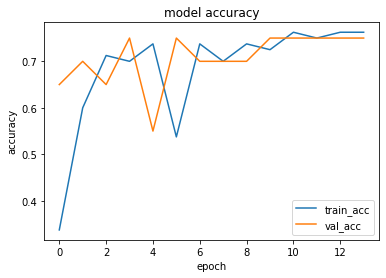

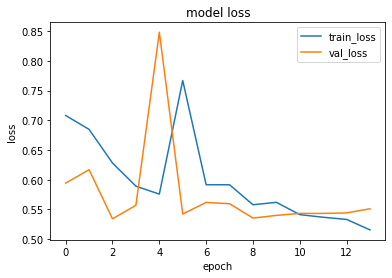

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5665369]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_3.mov is [[0.6767518]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.74725807]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.30180514]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.26848173]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.26306126]]


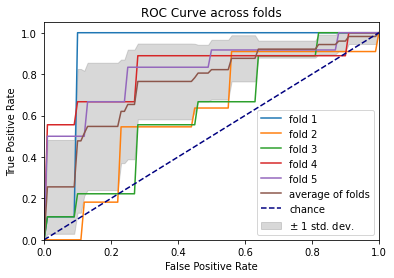

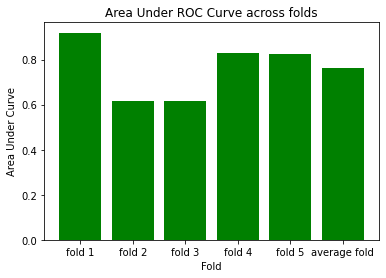

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

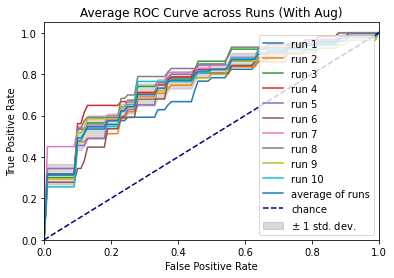

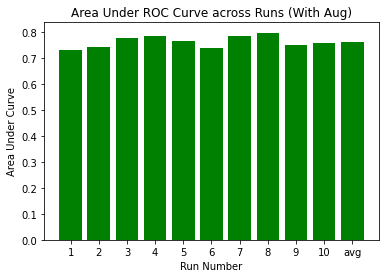

In [25]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [26]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7643749999999998, 0.020834429841472723)

In [34]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [43]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 

METRICS.append(interpret("3/3 [==============================] - 1s 306ms/step - loss: 0.6308 - accuracy: 0.5750 - precision_1: 0.6129 - recall_1: 0.4634 - val_loss: 0.4861 - val_accuracy: 0.9000 - val_precision_1: 0.8889 - val_recall_1: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 363ms/step - loss: 0.4195 - accuracy: 0.8625 - precision_2: 0.8889 - recall_2: 0.8205 - val_loss: 0.9539 - val_accuracy: 0.5000 - val_precision_2: 0.5556 - val_recall_2: 0.4545"))
METRICS.append(interpret("3/3 [==============================] - 1s 293ms/step - loss: 0.6004 - accuracy: 0.6625 - precision_3: 0.6591 - recall_3: 0.7073 - val_loss: 0.7144 - val_accuracy: 0.4500 - val_precision_3: 0.3750 - val_recall_3: 0.3333"))
METRICS.append(interpret("3/3 [==============================] - 1s 305ms/step - loss: 0.6156 - accuracy: 0.7250 - precision_4: 0.6939 - recall_4: 0.8293 - val_loss: 0.6275 - val_accuracy: 0.6000 - val_precision_4: 0.5333 - val_recall_4: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 300ms/step - loss: 0.5573 - accuracy: 0.7125 - precision_5: 0.6923 - recall_5: 0.7105 - val_loss: 0.5562 - val_accuracy: 0.7000 - val_precision_5: 0.8000 - val_recall_5: 0.6667"))
METRICS.append(interpret("3/3 [==============================] - 1s 295ms/step - loss: 0.5652 - accuracy: 0.7000 - precision_7: 0.6977 - recall_7: 0.7317 - val_loss: 0.3978 - val_accuracy: 0.9000 - val_precision_7: 0.8889 - val_recall_7: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 302ms/step - loss: 0.4078 - accuracy: 0.8625 - precision_8: 0.9118 - recall_8: 0.7949 - val_loss: 1.0291 - val_accuracy: 0.5500 - val_precision_8: 0.6000 - val_recall_8: 0.5455"))
METRICS.append(interpret("3/3 [==============================] - 1s 354ms/step - loss: 0.4514 - accuracy: 0.7875 - precision_9: 0.8158 - recall_9: 0.7561 - val_loss: 0.7548 - val_accuracy: 0.6500 - val_precision_9: 0.6250 - val_recall_9: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 336ms/step - loss: 0.4873 - accuracy: 0.7625 - precision_10: 0.7750 - recall_10: 0.7561 - val_loss: 0.5389 - val_accuracy: 0.7000 - val_precision_10: 0.6364 - val_recall_10: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 317ms/step - loss: 0.6526 - accuracy: 0.6875 - precision_11: 0.6444 - recall_11: 0.7632 - val_loss: 0.5497 - val_accuracy: 0.7000 - val_precision_11: 0.7500 - val_recall_11: 0.7500"))
METRICS.append(interpret("3/3 [==============================] - 1s 295ms/step - loss: 0.6039 - accuracy: 0.7250 - precision_13: 0.7714 - recall_13: 0.6585 - val_loss: 0.4992 - val_accuracy: 0.9000 - val_precision_13: 0.8889 - val_recall_13: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 304ms/step - loss: 0.3281 - accuracy: 0.8375 - precision_14: 0.8421 - recall_14: 0.8205 - val_loss: 1.1360 - val_accuracy: 0.6500 - val_precision_14: 0.6667 - val_recall_14: 0.7273"))
METRICS.append(interpret("3/3 [==============================] - 1s 307ms/step - loss: 0.4848 - accuracy: 0.7875 - precision_15: 0.8750 - recall_15: 0.6829 - val_loss: 0.7322 - val_accuracy: 0.6500 - val_precision_15: 0.6250 - val_recall_15: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 299ms/step - loss: 0.5345 - accuracy: 0.7125 - precision_16: 0.7045 - recall_16: 0.7561 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_16: 0.7000 - val_recall_16: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 297ms/step - loss: 0.5830 - accuracy: 0.7250 - precision_17: 0.7667 - recall_17: 0.6053 - val_loss: 0.5707 - val_accuracy: 0.7000 - val_precision_17: 0.8750 - val_recall_17: 0.5833"))
METRICS.append(interpret("3/3 [==============================] - 1s 293ms/step - loss: 0.4472 - accuracy: 0.8250 - precision_20: 0.8205 - recall_20: 0.8205 - val_loss: 0.7668 - val_accuracy: 0.5500 - val_precision_20: 0.6000 - val_recall_20: 0.5455"))
METRICS.append(interpret("3/3 [==============================] - 1s 302ms/step - loss: 0.4717 - accuracy: 0.7750 - precision_21: 0.8108 - recall_21: 0.7317 - val_loss: 0.6018 - val_accuracy: 0.6500 - val_precision_21: 0.6250 - val_recall_21: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 290ms/step - loss: 0.5456 - accuracy: 0.7375 - precision_22: 0.8333 - recall_22: 0.6098 - val_loss: 0.4706 - val_accuracy: 0.8000 - val_precision_22: 0.7778 - val_recall_22: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 298ms/step - loss: 0.5636 - accuracy: 0.7000 - precision_23: 0.6667 - recall_23: 0.7368 - val_loss: 0.5220 - val_accuracy: 0.6500 - val_precision_23: 0.6667 - val_recall_23: 0.8333"))
METRICS.append(interpret("3/3 [==============================] - 1s 354ms/step - loss: 0.5927 - accuracy: 0.6750 - precision_25: 0.7586 - recall_25: 0.5366 - val_loss: 0.4474 - val_accuracy: 0.9000 - val_precision_25: 1.0000 - val_recall_25: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 308ms/step - loss: 0.4667 - accuracy: 0.7625 - precision_26: 0.7381 - recall_26: 0.7949 - val_loss: 0.9389 - val_accuracy: 0.6500 - val_precision_26: 0.7000 - val_recall_26: 0.6364"))
METRICS.append(interpret("3/3 [==============================] - 1s 303ms/step - loss: 0.4637 - accuracy: 0.7875 - precision_27: 0.7857 - recall_27: 0.8049 - val_loss: 0.6741 - val_accuracy: 0.6500 - val_precision_27: 0.6250 - val_recall_27: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 317ms/step - loss: 0.5102 - accuracy: 0.7250 - precision_28: 0.7209 - recall_28: 0.7561 - val_loss: 0.6081 - val_accuracy: 0.7500 - val_precision_28: 0.7000 - val_recall_28: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 295ms/step - loss: 0.5246 - accuracy: 0.7375 - precision_29: 0.7742 - recall_29: 0.6316 - val_loss: 0.5293 - val_accuracy: 0.8000 - val_precision_29: 0.8333 - val_recall_29: 0.8333"))
METRICS.append(interpret("3/3 [==============================] - 1s 297ms/step - loss: 0.6477 - accuracy: 0.6250 - precision_31: 0.5846 - recall_31: 0.9268 - val_loss: 0.5963 - val_accuracy: 0.5500 - val_precision_31: 0.5000 - val_recall_31: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 326ms/step - loss: 0.4663 - accuracy: 0.7875 - precision_32: 0.7750 - recall_32: 0.7949 - val_loss: 0.8342 - val_accuracy: 0.6000 - val_precision_32: 0.6364 - val_recall_32: 0.6364"))
METRICS.append(interpret("3/3 [==============================] - 1s 294ms/step - loss: 0.4623 - accuracy: 0.7750 - precision_33: 0.7949 - recall_33: 0.7561 - val_loss: 0.7570 - val_accuracy: 0.6500 - val_precision_33: 0.6000 - val_recall_33: 0.6667"))
METRICS.append(interpret("3/3 [==============================] - 1s 353ms/step - loss: 0.6229 - accuracy: 0.6875 - precision_34: 0.6481 - recall_34: 0.8537 - val_loss: 0.6631 - val_accuracy: 0.7000 - val_precision_34: 0.6364 - val_recall_34: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 298ms/step - loss: 0.5451 - accuracy: 0.7500 - precision_35: 0.7368 - recall_35: 0.7368 - val_loss: 0.5553 - val_accuracy: 0.8000 - val_precision_35: 0.8333 - val_recall_35: 0.8333"))
METRICS.append(interpret("3/3 [==============================] - 1s 295ms/step - loss: 0.5395 - accuracy: 0.7625 - precision_37: 0.8056 - recall_37: 0.7073 - val_loss: 0.4449 - val_accuracy: 0.9000 - val_precision_37: 1.0000 - val_recall_37: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 296ms/step - loss: 0.4653 - accuracy: 0.7625 - precision_38: 0.7174 - recall_38: 0.8462 - val_loss: 0.8774 - val_accuracy: 0.5500 - val_precision_38: 0.6000 - val_recall_38: 0.5455"))
METRICS.append(interpret("3/3 [==============================] - 1s 290ms/step - loss: 0.4751 - accuracy: 0.8000 - precision_39: 0.8205 - recall_39: 0.7805 - val_loss: 0.6824 - val_accuracy: 0.6000 - val_precision_39: 0.5714 - val_recall_39: 0.4444"))
METRICS.append(interpret("3/3 [==============================] - 1s 287ms/step - loss: 0.4993 - accuracy: 0.7250 - precision_40: 0.7436 - recall_40: 0.7073 - val_loss: 0.4975 - val_accuracy: 0.7500 - val_precision_40: 0.6667 - val_recall_40: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 348ms/step - loss: 0.5300 - accuracy: 0.7625 - precision_41: 0.7436 - recall_41: 0.7632 - val_loss: 0.5687 - val_accuracy: 0.7000 - val_precision_41: 0.6875 - val_recall_41: 0.9167"))
METRICS.append(interpret("3/3 [==============================] - 1s 288ms/step - loss: 0.6658 - accuracy: 0.6500 - precision_43: 0.6585 - recall_43: 0.6585 - val_loss: 0.3988 - val_accuracy: 0.9000 - val_precision_43: 0.8889 - val_recall_43: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 342ms/step - loss: 0.4250 - accuracy: 0.8250 - precision_44: 0.9032 - recall_44: 0.7179 - val_loss: 0.8696 - val_accuracy: 0.7000 - val_precision_44: 0.7778 - val_recall_44: 0.6364"))
METRICS.append(interpret("3/3 [==============================] - 1s 289ms/step - loss: 0.4256 - accuracy: 0.7875 - precision_45: 0.8333 - recall_45: 0.7317 - val_loss: 0.6478 - val_accuracy: 0.7000 - val_precision_45: 0.6667 - val_recall_45: 0.6667"))
METRICS.append(interpret("3/3 [==============================] - 1s 337ms/step - loss: 0.5560 - accuracy: 0.7500 - precision_46: 0.7561 - recall_46: 0.7561 - val_loss: 0.4913 - val_accuracy: 0.7500 - val_precision_46: 0.7000 - val_recall_46: 0.7778"))
METRICS.append(interpret("3/3 [==============================] - 1s 298ms/step - loss: 0.5526 - accuracy: 0.7500 - precision_47: 0.7647 - recall_47: 0.6842 - val_loss: 0.5632 - val_accuracy: 0.7500 - val_precision_47: 0.8182 - val_recall_47: 0.7500"))
METRICS.append(interpret("3/3 [==============================] - 1s 293ms/step - loss: 0.5674 - accuracy: 0.7250 - precision_49: 0.7209 - recall_49: 0.7561 - val_loss: 0.3659 - val_accuracy: 0.9500 - val_precision_49: 0.9000 - val_recall_49: 1.0000"))
METRICS.append(interpret("3/3 [==============================] - 1s 289ms/step - loss: 0.4810 - accuracy: 0.7500 - precision_50: 0.7436 - recall_50: 0.7436 - val_loss: 0.8355 - val_accuracy: 0.5500 - val_precision_50: 0.6000 - val_recall_50: 0.5455"))
METRICS.append(interpret("3/3 [==============================] - 1s 350ms/step - loss: 0.5182 - accuracy: 0.7750 - precision_51: 0.8286 - recall_51: 0.7073 - val_loss: 0.6801 - val_accuracy: 0.6000 - val_precision_51: 0.5556 - val_recall_51: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 302ms/step - loss: 0.6026 - accuracy: 0.6625 - precision_52: 0.7333 - recall_52: 0.5366 - val_loss: 0.5189 - val_accuracy: 0.8000 - val_precision_52: 1.0000 - val_recall_52: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 291ms/step - loss: 0.5301 - accuracy: 0.8000 - precision_53: 0.8056 - recall_53: 0.7632 - val_loss: 0.5463 - val_accuracy: 0.7500 - val_precision_53: 0.7692 - val_recall_53: 0.8333"))
METRICS.append(interpret("3/3 [==============================] - 1s 289ms/step - loss: 0.5886 - accuracy: 0.6750 - precision_55: 0.7586 - recall_55: 0.5366 - val_loss: 0.4677 - val_accuracy: 0.9000 - val_precision_55: 0.8889 - val_recall_55: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 293ms/step - loss: 0.5674 - accuracy: 0.7250 - precision_49: 0.7209 - recall_49: 0.7561 - val_loss: 0.3659 - val_accuracy: 0.9500 - val_precision_49: 0.9000 - val_recall_49: 1.0000"))
METRICS.append(interpret("3/3 [==============================] - 1s 297ms/step - loss: 0.4939 - accuracy: 0.7625 - precision_56: 0.7632 - recall_56: 0.7436 - val_loss: 0.8071 - val_accuracy: 0.5500 - val_precision_56: 0.5833 - val_recall_56: 0.6364"))
METRICS.append(interpret("3/3 [==============================] - 1s 317ms/step - loss: 0.4857 - accuracy: 0.7750 - precision_57: 0.7674 - recall_57: 0.8049 - val_loss: 0.6985 - val_accuracy: 0.6500 - val_precision_57: 0.6250 - val_recall_57: 0.5556"))
METRICS.append(interpret("3/3 [==============================] - 1s 288ms/step - loss: 0.5361 - accuracy: 0.7375 - precision_58: 0.7273 - recall_58: 0.7805 - val_loss: 0.5726 - val_accuracy: 0.6500 - val_precision_58: 0.5714 - val_recall_58: 0.8889"))
METRICS.append(interpret("3/3 [==============================] - 1s 291ms/step - loss: 0.5155 - accuracy: 0.7625 - precision_59: 0.7568 - recall_59: 0.7368 - val_loss: 0.5511 - val_accuracy: 0.7500 - val_precision_59: 0.7692 - val_recall_59: 0.8333"))

In [44]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [47]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.744 ± 0.057
training precision : 0.757 ± 0.071
training recall : 0.731 ± 0.087
validation accuracy : 0.708 ± 0.123
validation precision : 0.714 ± 0.141
validation recall : 0.717 ± 0.154


In [50]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.74 ± 0.059
validation F1 : 0.708 ± 0.129


In [65]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

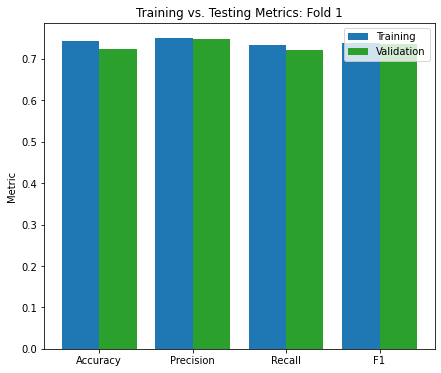

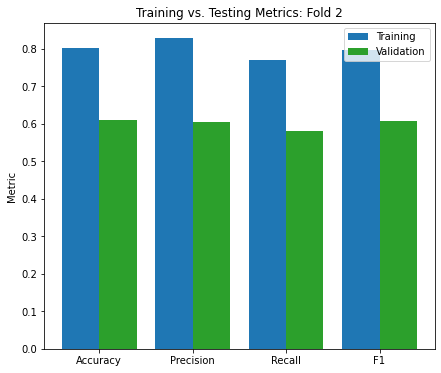

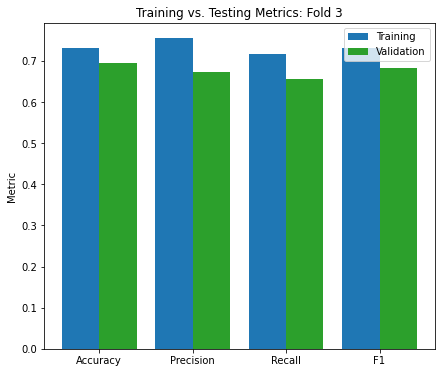

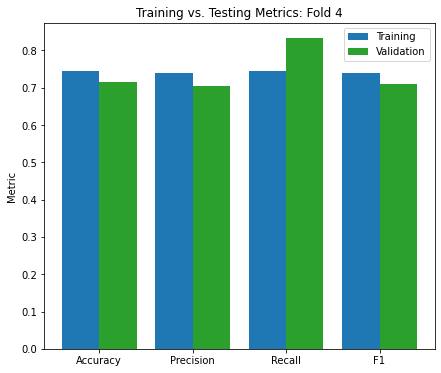

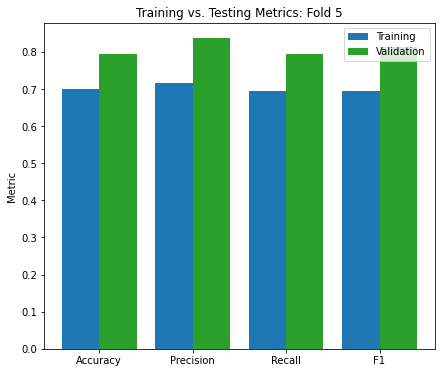

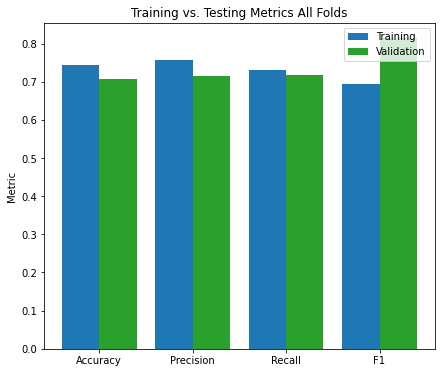

In [162]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1}")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all.png")
    plt.show()